# * TOL Performance

## Import Data Source

In [148]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from functools import reduce
import datetime

mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

In [149]:
as_week = 2023023
data_src = f"../../data/raw/Raw-Agg Perf Nationwide_Wk {as_week}.csv"
df = pd.read_csv(data_src, low_memory=False)
cols = ['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'ACTUAL_AS_OF', 'AGG_TYPE', 'RR_IND', 'GRY_IND', 'UOM', 'PERIOD', 'ACTUAL_SNAP', 'ACTUAL_AGG', 'TARGET_SNAP', 'TARGET_AGG', 'PPN_TM']
df = df[cols]

''' Fix Metric CD List '''
tol_rev_cd_list = ['TB3R000100', 'TB3R000101', 'TB3R000102']
tol_sub_cd_list = ['TB3S000100', 'TB3S000101', 'TB3S000400', 'TB3S000500', 'TSER13100']# Include "TOL Churn Subs"
tol_all_cd_list = tol_rev_cd_list + tol_sub_cd_list

In [150]:
df.shape

(55020, 22)

In [9]:
# ''' Find Metric '''

# df_agg_s = df[df['AGG_TYPE']=='S'].groupby(['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'AGG_TYPE']).agg({'ACTUAL_SNAP': 'sum', 'TARGET_SNAP': 'sum'}).reset_index()
# df_agg_n = df.loc[df[df['AGG_TYPE']=='N'].groupby('METRIC_CD')['TM_KEY_DAY'].idxmax()].reset_index()
# df_agg_n = df_agg_n[['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'AGG_TYPE', 'ACTUAL_SNAP', 'TARGET_SNAP']]
# df_metric = pd.concat([df_agg_s, df_agg_n])
# # df_metric

# df_tmp = df_metric[df_metric['PRODUCT_GRP']=="TOL"]#.reset_index()
# # df_tmp = df_tmp[df_tmp['CENTER']=="Sales & Revenue"]
# # df_tmp = df_tmp[df_tmp['METRIC_GRP']=="Revenue"]
# # df_tmp = df_tmp[df_tmp['METRIC_NAME'].str.contains("Revenue")].reset_index()
# # df_tmp = df_tmp[df_tmp['METRIC_NAME'].str.contains("Sub")]#.reset_index()

# # df_tmp.to_excel('TOL_Metric.xlsx', index=False)
# df_tmp.sort_values(by=['CENTER', 'METRIC_GRP', 'COMP_CD', 'METRIC_CD'])

## Data Preporation

In [151]:
''' Rawdata '''

''' Function : Unit Million Baht '''
def unit_mb(baht):
    n = baht
    unit_mb = n / 1000000
    return unit_mb

''' Filters '''
# df = df[df['TM_KEY_MTH'] <= 202305] # MONTH filter
# df = df[df['TM_KEY_WK'] <= 2023022] # WEEK filter
# df = df[df['TM_KEY_DAY'] <= 20230611] # DAY filter
df = df[df['METRIC_CD'].isin(tol_all_cd_list)]

''' Modify '''
df = df.rename(columns={'ACTUAL_SNAP':'ACT_SNAP', 'ACTUAL_AGG':'ACT_AGG', 'TARGET_SNAP':'TGT_SNAP', 'TARGET_AGG':'TGT_AGG'})
# df.loc[:, 'ACT_SNAP'] = unit_mb(df['ACT_SNAP'])
# df.loc[:, 'ACT_AGG'] = unit_mb(df['ACT_AGG'])
# df.loc[:, 'TGT_SNAP'] = unit_mb(df['TGT_SNAP'])
# df.loc[:, 'TGT_AGG'] = unit_mb(df['TGT_AGG'])

''' Add new column '''
df['MTH_DESC'] = pd.to_datetime(df['TM_KEY_MTH'], format='%Y%m', errors='coerce').dt.strftime('%B')
df['WK_LABEL'] = df['TM_KEY_WK'].apply(str).str[5:].astype(int)
df['DAY_LABEL'] = df['TM_KEY_DAY'].apply(str).str[6:].astype(int)

df.tail(3)

,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,CENTER,METRIC_GRP,COMP_CD,PRODUCT_GRP,METRIC_CD,...,UOM,PERIOD,ACT_SNAP,ACT_AGG,TGT_SNAP,TGT_AGG,PPN_TM,MTH_DESC,WK_LABEL,DAY_LABEL
47142,20230611,2023023,202306,20232,2023,Sales & Revenue,Revenue,TRUE,TOL,TB3R000100,...,baht,M,NaN,5.140599e+08,NaN,5.415177e+08,2023-06-14 16:35:31,June,23,11
47143,20230612,2023024,202306,20232,2023,Sales & Revenue,Revenue,TRUE,TOL,TB3R000100,...,baht,M,NaN,5.140599e+08,NaN,5.415177e+08,2023-06-14 16:35:31,June,24,12
47144,20230613,2023024,202306,20232,2023,Sales & Revenue,Revenue,TRUE,TOL,TB3R000100,...,baht,M,NaN,5.140599e+08,NaN,5.415177e+08,2023-06-14 16:35:31,June,24,13


In [152]:
''' Create Dataframe '''

''' Aggregate type : S '''
df_agg_s = df[df['AGG_TYPE']=='S']
df_agg_s = df_agg_s.rename(columns={'ACT_SNAP':'ACT', 'TGT_SNAP':'TGT'})

''' Aggregate type : N '''
df_agg_n = df[df['AGG_TYPE']=='N'].dropna(subset='ACT_SNAP')
df_agg_n = df_agg_n.rename(columns={'ACT_SNAP':'ACT', 'TGT_SNAP':'TGT'})

In [153]:
''' Period Values '''

curr_yr = df['TM_KEY_YR'].max()
last_yr = df['TM_KEY_YR'].max() - 1
curr_mth = df['TM_KEY_MTH'].max()
curr_mth_desc = pd.to_datetime(curr_mth, format='%Y%m', errors='coerce').strftime('%B')
last_mth = int(f'{str(last_yr)}12') if str(curr_mth)[4:]=='01' else curr_mth-1
curr_wk = df['TM_KEY_WK'].max()
last_wk = df['TM_KEY_WK'].drop_duplicates().shift().max()
curr_day = df['TM_KEY_DAY'].max()
last_ppn_tm = df['PPN_TM'].max()

### DAY : Aggregation (base level)

In [154]:
''' Create Dataframe '''

cols_agg = ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'MTH_DESC', 'DAY_LABEL', 'AGG_TYPE', 'ACT_SNAP', 'ACT_AGG', 'TGT_SNAP', 'TGT_AGG']
df_rev_day = df[cols_agg].reset_index()

''' Aggregation '''
df_rev_day['ACT'] = np.where(df_rev_day['AGG_TYPE']=='N', df_rev_day['ACT_AGG'], df_rev_day['ACT_SNAP'])
df_rev_day['TGT'] = np.where(df_rev_day['AGG_TYPE']=='N', df_rev_day['TGT_AGG'], df_rev_day['TGT_SNAP'])
df_rev_day['%ACHV'] = df_rev_day['ACT'] / df_rev_day['TGT']
df_rev_day['GAP'] = df_rev_day['ACT'] - df_rev_day['TGT']
df_rev_day['LAST_ACT'] = df_rev_day.groupby('METRIC_CD')['ACT'].shift()
df_rev_day['DIFF'] = df_rev_day['ACT'] - df_rev_day['LAST_ACT']
df_rev_day['%DOD'] = (df_rev_day['ACT'] / df_rev_day['LAST_ACT']) - 1

df_rev_day.tail(3)

,index,METRIC_CD,METRIC_NAME,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,MTH_DESC,DAY_LABEL,...,ACT_AGG,TGT_SNAP,TGT_AGG,ACT,TGT,%ACHV,GAP,LAST_ACT,DIFF,%DOD
837,47142,TB3R000100,TOL Revenue,20230611,2023023,202306,20232,2023,June,11,...,5.140599e+08,NaN,5.415177e+08,NaN,NaN,NaN,NaN,2.078150e+08,NaN,NaN
838,47143,TB3R000100,TOL Revenue,20230612,2023024,202306,20232,2023,June,12,...,5.140599e+08,NaN,5.415177e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
839,47144,TB3R000100,TOL Revenue,20230613,2023024,202306,20232,2023,June,13,...,5.140599e+08,NaN,5.415177e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [155]:
''' Fix Columns Dict '''

cols_dict = {'TOL Revenue':'TOTAL', 'TOL New Revenue':'NEW', 'TOL Exisitng Revenue':'EXIST', 
             'TOL Connected Subs':'CON_SUB', 'TOL Registration Subs':'REG_SUB', 'TOL Net Add':'NET_ADD', 'TOL Active Subs':'ACTV_SUB', 'TOL Churn Subs':'CHRN_SUB'}

In [156]:
''' Pivot by KPIS '''

df_rev_day_agg = df_rev_day.pivot(index=['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'MTH_DESC', 'DAY_LABEL'], columns='METRIC_NAME', 
                                  values=['ACT', 'TGT', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%DOD']).rename(columns=cols_dict).reset_index()
df_rev_day_agg.tail(3)

TM_KEY_DAY TM_KEY_WK TM_KEY_MTH TM_KEY_QTR TM_KEY_YR MTH_DESC  \
METRIC_NAME                                                                 
102           20230611   2023023     202306      20232      2023     June   
103           20230612   2023024     202306      20232      2023     June   
104           20230613   2023024     202306      20232      2023     June   

            DAY_LABEL        ACT                   ...    DIFF        \
METRIC_NAME             ACTV_SUB CHRN_SUB CON_SUB  ... REG_SUB TOTAL   
102                11  3050765.0      NaN  1494.0  ...  -146.0   NaN   
103                12  3050765.0      NaN  1571.0  ...   248.0   NaN   
104                13  3052332.0      NaN  1485.0  ...   -21.0   NaN   

                 %DOD                                                       
METRIC_NAME  ACTV_SUB CHRN_SUB   CON_SUB EXIST NET_ADD NEW   REG_SUB TOTAL  
102         -0.000068      NaN -0.152100   NaN     NaN NaN -0.083524   NaN  
103          0.000000      NaN  0.051539   NaN     NaN NaN  0.154806   NaN  
104          0.000514      NaN -0.054742   NaN     NaN NaN -0.011351   NaN  

[3 rows x 63 columns]

## ** Yearly

### YR : Aggregation

In [157]:
''' Create Dataframe '''

df_agg_s_yr = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_YR', 'AGG_TYPE']).agg({'ACT': 'sum', 'TGT': 'sum'}).reset_index()
df_agg_n_yr = df_agg_n.loc[df_agg_n.groupby('TM_KEY_YR')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_YR', 'AGG_TYPE', 'ACT', 'TGT']]
df_rev_yr = pd.concat([df_agg_s_yr, df_agg_n_yr])

''' Aggregation '''
df_rev_yr['%ACHV'] = df_rev_yr['ACT'] / df_rev_yr['TGT']
df_rev_yr['GAP'] = df_rev_yr['ACT'] - df_rev_yr['TGT']
df_rev_yr['LAST_ACT'] = df_rev_yr.groupby('METRIC_CD')['ACT'].shift()
df_rev_yr['DIFF'] = df_rev_yr['ACT'] - df_rev_yr['LAST_ACT']
df_rev_yr['%YOY'] = (df_rev_yr['ACT'] / df_rev_yr['LAST_ACT']) - 1

df_rev_yr#.tail()

,METRIC_CD,METRIC_NAME,TM_KEY_YR,AGG_TYPE,ACT,TGT,%ACHV,GAP,LAST_ACT,DIFF,%YOY
0,TB3R000100,TOL Revenue,2023,S,4.593280e+09,5.062014e+09,0.907402,-4.687345e+08,NaN,NaN,NaN
1,TB3R000101,TOL New Revenue,2023,S,3.644179e+08,5.393788e+08,0.675625,-1.749610e+08,NaN,NaN,NaN
2,TB3R000102,TOL Exisitng Revenue,2023,S,4.228862e+09,4.524167e+09,0.934727,-2.953049e+08,NaN,NaN,NaN
3,TB3S000100,TOL Connected Subs,2023,S,1.904160e+05,2.477515e+05,0.768576,-5.733555e+04,NaN,NaN,NaN
4,TB3S000101,TOL Registration Subs,2023,S,2.342200e+05,0.000000e+00,inf,2.342200e+05,NaN,NaN,NaN
5,TB3S000400,TOL Net Add,2023,S,3.362000e+04,1.456882e+05,0.230767,-1.120682e+05,NaN,NaN,NaN
6,TSER13100,TOL Churn Subs,2023,S,1.504840e+05,9.266700e+04,1.623922,5.781700e+04,NaN,NaN,NaN
45569,TB3S000500,TOL Active Subs,2023,N,3.052332e+06,3.183039e+06,0.958936,-1.307075e+05,NaN,NaN,NaN


In [158]:
''' Pivot by KPIS '''

df_rev_yr_agg = df_rev_yr.pivot(index='TM_KEY_YR', columns='METRIC_NAME', 
                                values=['ACT', 'TGT', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%YOY']).rename(columns=cols_dict).reset_index()
df_rev_yr_agg.tail(3)

TM_KEY_YR        ACT                                             \
METRIC_NAME             ACTV_SUB  CHRN_SUB   CON_SUB         EXIST  NET_ADD   
0                2023  3052332.0  150484.0  190416.0  4.228862e+09  33620.0   

                                                         TGT  ...    DIFF  \
METRIC_NAME           NEW   REG_SUB         TOTAL   ACTV_SUB  ... REG_SUB   
0            3.644179e+08  234220.0  4.593280e+09  3183039.5  ...     NaN   

                      %YOY                                                   
METRIC_NAME TOTAL ACTV_SUB CHRN_SUB CON_SUB EXIST NET_ADD NEW REG_SUB TOTAL  
0             NaN      NaN      NaN     NaN   NaN     NaN NaN     NaN   NaN  

[1 rows x 57 columns]

In [159]:
df_rev_day_agg[df_rev_day_agg['TM_KEY_YR']==curr_yr]['ACT']['ACTV_SUB']#.sum()

0      3029417.0
1      3030081.0
2      3030081.0
3      3030081.0
4      3030081.0
         ...    
100    3050973.0
101    3050973.0
102    3050765.0
103    3050765.0
104    3052332.0
Name: ACTV_SUB, Length: 105, dtype: float64

In [161]:
df_rev_day_agg[df_rev_day_agg['TM_KEY_YR']==curr_yr]#['ACT']

TM_KEY_DAY TM_KEY_WK TM_KEY_MTH TM_KEY_QTR TM_KEY_YR MTH_DESC  \
METRIC_NAME                                                                 
0             20230301   2023009     202303      20231      2023    March   
1             20230302   2023009     202303      20231      2023    March   
2             20230303   2023009     202303      20231      2023    March   
3             20230304   2023009     202303      20231      2023    March   
4             20230305   2023009     202303      20231      2023    March   
..                 ...       ...        ...        ...       ...      ...   
100           20230609   2023023     202306      20232      2023     June   
101           20230610   2023023     202306      20232      2023     June   
102           20230611   2023023     202306      20232      2023     June   
103           20230612   2023024     202306      20232      2023     June   
104           20230613   2023024     202306      20232      2023     June   

            DAY_LABEL        ACT                   ...    DIFF        \
METRIC_NAME             ACTV_SUB CHRN_SUB CON_SUB  ... REG_SUB TOTAL   
0                   1  3029417.0    662.0  1935.0  ...     NaN   NaN   
1                   2  3030081.0    732.0  1765.0  ...   898.0   NaN   
2                   3  3030081.0    733.0  1995.0  ...    17.0   NaN   
3                   4  3030081.0    684.0  2087.0  ...  -240.0   NaN   
4                   5  3030081.0   4226.0  1944.0  ...  -574.0   NaN   
..                ...        ...      ...     ...  ...     ...   ...   
100                 9  3050973.0    597.0  1652.0  ...   -95.0   NaN   
101                10  3050973.0      NaN  1762.0  ...  -192.0   NaN   
102                11  3050765.0      NaN  1494.0  ...  -146.0   NaN   
103                12  3050765.0      NaN  1571.0  ...   248.0   NaN   
104                13  3052332.0      NaN  1485.0  ...   -21.0   NaN   

                 %DOD                                                          
METRIC_NAME  ACTV_SUB  CHRN_SUB   CON_SUB EXIST   NET_ADD NEW   REG_SUB TOTAL  
0                 NaN       NaN       NaN   NaN       NaN NaN       NaN   NaN  
1            0.000219  0.105740 -0.087855   NaN -0.188531 NaN  0.450577   NaN  
2            0.000000  0.001366  0.130312   NaN  0.221684 NaN  0.005880   NaN  
3            0.000000 -0.066849  0.046115   NaN  0.111727 NaN -0.082531   NaN  
4            0.000000  5.178363 -0.068519   NaN -2.626515 NaN -0.215142   NaN  
..                ...       ...       ...   ...       ...  ..       ...   ...  
100         -0.000044 -0.274605  0.063748   NaN  0.445205 NaN -0.046683   NaN  
101          0.000000       NaN  0.066586   NaN       NaN NaN -0.098969   NaN  
102         -0.000068       NaN -0.152100   NaN       NaN NaN -0.083524   NaN  
103          0.000000       NaN  0.051539   NaN       NaN NaN  0.154806   NaN  
104          0.000514       NaN -0.054742   NaN       NaN NaN -0.011351   NaN  

[105 rows x 63 columns]

In [162]:
len(df_rev_day_agg[df_rev_day_agg['TM_KEY_YR']==curr_yr]['TM_KEY_DAY'].unique())

105

In [181]:
''' Year to Date Values '''

day_cnt_curr_yr = len(df_rev_day_agg[df_rev_day_agg['TM_KEY_YR']==curr_yr]['TM_KEY_DAY'].unique())
day_cnt_last_yr = len(df_rev_day_agg[df_rev_day_agg['TM_KEY_YR']==last_yr]['TM_KEY_DAY'].unique())
rev_last_yr = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==last_yr]['ACT']['TOTAL'].sum()
# rev_last_yr

# ''' Revenue '''
# ytd_rev = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==curr_yr]['ACT']['TOTAL'].sum()
# ytd_tgt = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==curr_yr]['TGT']['TOTAL'].sum()
# ytd_achv = ytd_rev / ytd_tgt
# ytd_last_rev = (ytd_rev / day_cnt_last_yr) * day_cnt_curr_yr
# ytd_yoy = (ytd_rev / ytd_last_rev) - 1
# ytd_gap = ytd_rev - ytd_last_rev

# ''' Subs '''
# ytd_actv_sub = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==curr_yr]['ACT']['ACTV_SUB'].sum()
# ytd_tgt_actv_sub = df_rev_yr_agg[df_rev_yr_agg['TM_KEY_YR']==curr_yr]['TGT']['ACTV_SUB'].sum()
# ytd_achv_actv_sub = ytd_actv_sub / ytd_tgt_actv_sub
# ytd_last_actv_sub = (ytd_actv_sub / day_cnt_last_yr) * day_cnt_curr_yr
# # ytd_yoy_actv_sub = (ytd_rev / ytd_last_rev) - 1
# # ytd_gap_actv_sub = ytd_rev - ytd_last_rev

# ytd_last_actv_sub

0.0

In [123]:
''' Year to Date Values '''

df_last_yr = df_rev_day_agg[df_rev_day_agg['TM_KEY_YR']==last_yr][['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_YR', 'ACT', 'TGT']]
day_cnt_curr_yr = len(df_rev_day_agg[(df_rev_day_agg['TM_KEY_YR']==curr_yr) & (df_rev_day_agg['ACT']['TOTAL']>0)]['TM_KEY_DAY'].unique())

''' Revenue '''
ytd_last_act = (df_last_yr['ACT']['TOTAL'].sum() / len(df_last_yr['TM_KEY_DAY'].unique())) * day_cnt_curr_yr
ytd_act = df_rev_day_agg[df_rev_day_agg['TM_KEY_YR']==curr_yr]['ACT']['TOTAL'].sum()
ytd_tgt = df_rev_day_agg[df_rev_day_agg['TM_KEY_YR']==curr_yr]['TGT']['TOTAL'].sum()
ytd_achv = ytd_act / ytd_tgt
ytd_yoy = (ytd_act / ytd_last_act) - 1
ytd_act_gap = ytd_act - ytd_last_act

''' Subs '''
ytd_last_act_actv_sub = (df_last_yr['ACT']['ACTV_SUB'].sum() / len(df_last_yr['TM_KEY_DAY'].unique())) * day_cnt_curr_yr
ytd_act_actv_sub = df_rev_day_agg[df_rev_day_agg['TM_KEY_YR']==curr_yr]['ACT']['ACTV_SUB'].sum()
ytd_tgt_actv_sub = df_rev_day_agg[df_rev_day_agg['TM_KEY_YR']==curr_yr]['TGT']['ACTV_SUB'].sum()
ytd_achv_actv_sub = ytd_act_actv_sub / ytd_tgt_actv_sub
ytd_yoy_actv_sub = (ytd_act_actv_sub / ytd_last_act_actv_sub) - 1
ytd_act_gap_actv_sub = ytd_act_actv_sub - ytd_last_act_actv_sub

C:\Users\Narut4\AppData\Local\Temp\ipykernel_6332\3068728648.py:7: RuntimeWarning: invalid value encountered in scalar divide
  ytd_last_act = (df_last_yr['ACT']['TOTAL'].sum() / len(df_last_yr['TM_KEY_DAY'].unique())) * day_cnt_curr_yr
C:\Users\Narut4\AppData\Local\Temp\ipykernel_6332\3068728648.py:15: RuntimeWarning: invalid value encountered in scalar divide
  ytd_last_act_actv_sub = (df_last_yr['ACT']['ACTV_SUB'].sum() / len(df_last_yr['TM_KEY_DAY'].unique())) * day_cnt_curr_yr


In [124]:
''' Year Chart Values '''

x_yr = df_rev_yr_agg['TM_KEY_YR']
x_yr_axis = np.arange(len(x_yr))

''' TOTAL : Values '''
y_yr_act = df_rev_yr_agg['ACT']['TOTAL']
y_yr_tgt = df_rev_yr_agg['TGT']['TOTAL']
y_yr_achv = df_rev_yr_agg['%ACHV']['TOTAL']
y_yr_gap = df_rev_yr_agg['GAP']['TOTAL']
y_yr_diff = df_rev_yr_agg['DIFF']['TOTAL']
y_yr_last_act = df_rev_yr_agg['LAST_ACT']['TOTAL']
y_yr_yoy = df_rev_yr_agg['%YOY']['TOTAL']

''' NEW : Values '''
y_yr_act_new = df_rev_yr_agg['ACT']['NEW']
y_yr_tgt_new = df_rev_yr_agg['TGT']['NEW']
y_yr_achv_new = df_rev_yr_agg['%ACHV']['NEW']
y_yr_gap_new = df_rev_yr_agg['GAP']['NEW']
y_yr_diff_new = df_rev_yr_agg['DIFF']['NEW']
y_yr_last_act_new = df_rev_yr_agg['LAST_ACT']['NEW']
y_yr_yoy_new = df_rev_yr_agg['%YOY']['NEW']

''' EXIST : Values '''
y_yr_act_exist = df_rev_yr_agg['ACT']['EXIST']
y_yr_tgt_exist = df_rev_yr_agg['TGT']['EXIST']
y_yr_achv_exist = df_rev_yr_agg['%ACHV']['EXIST']
y_yr_gap_exist = df_rev_yr_agg['GAP']['EXIST']
y_yr_diff_exist = df_rev_yr_agg['DIFF']['EXIST']
y_yr_last_act_exist = df_rev_yr_agg['LAST_ACT']['EXIST']
y_yr_yoy_exist = df_rev_yr_agg['%YOY']['EXIST']

''' ACTV_SUB : Values '''
y_yr_act_actv_sub = df_rev_yr_agg['ACT']['ACTV_SUB']
y_yr_tgt_actv_sub = df_rev_yr_agg['TGT']['ACTV_SUB']
y_yr_achv_actv_sub = df_rev_yr_agg['%ACHV']['ACTV_SUB']
y_yr_gap_actv_sub = df_rev_yr_agg['GAP']['ACTV_SUB']
y_yr_diff_actv_sub = df_rev_yr_agg['DIFF']['ACTV_SUB']
y_yr_last_act_actv_sub = df_rev_yr_agg['LAST_ACT']['ACTV_SUB']
y_yr_yoy_actv_sub = df_rev_yr_agg['%YOY']['ACTV_SUB']

''' CON_SUB : Values '''
y_yr_act_con_sub = df_rev_yr_agg['ACT']['CON_SUB']
y_yr_tgt_con_sub = df_rev_yr_agg['TGT']['CON_SUB']
y_yr_achv_con_sub = df_rev_yr_agg['%ACHV']['CON_SUB']
y_yr_gap_con_sub = df_rev_yr_agg['GAP']['CON_SUB']
y_yr_diff_con_sub = df_rev_yr_agg['DIFF']['CON_SUB']
y_yr_last_act_con_sub = df_rev_yr_agg['LAST_ACT']['CON_SUB']
y_yr_yoy_con_sub = df_rev_yr_agg['%YOY']['CON_SUB']

''' REG_SUB : Values '''
y_yr_act_reg_sub = df_rev_yr_agg['ACT']['REG_SUB']
y_yr_tgt_reg_sub = df_rev_yr_agg['TGT']['REG_SUB']
y_yr_achv_reg_sub = df_rev_yr_agg['%ACHV']['REG_SUB']
y_yr_gap_reg_sub = df_rev_yr_agg['GAP']['REG_SUB']
y_yr_diff_reg_sub = df_rev_yr_agg['DIFF']['REG_SUB']
y_yr_last_act_reg_sub = df_rev_yr_agg['LAST_ACT']['REG_SUB']
y_yr_yoy_reg_sub = df_rev_yr_agg['%YOY']['REG_SUB']

''' CHRN_SUB : Values '''
y_yr_act_chrn_sub = df_rev_yr_agg['ACT']['CHRN_SUB']
y_yr_tgt_chrn_sub = df_rev_yr_agg['TGT']['CHRN_SUB']
y_yr_achv_chrn_sub = df_rev_yr_agg['%ACHV']['CHRN_SUB']
y_yr_gap_chrn_sub = df_rev_yr_agg['GAP']['CHRN_SUB']
y_yr_diff_chrn_sub = df_rev_yr_agg['DIFF']['CHRN_SUB']
y_yr_last_act_chrn_sub = df_rev_yr_agg['LAST_ACT']['CHRN_SUB']
y_yr_yoy_chrn_sub = df_rev_yr_agg['%YOY']['CHRN_SUB']

''' NET_ADD : Values '''
y_yr_act_net_add = df_rev_yr_agg['ACT']['NET_ADD']
y_yr_tgt_net_add = df_rev_yr_agg['TGT']['NET_ADD']
y_yr_achv_net_add = df_rev_yr_agg['%ACHV']['NET_ADD']
y_yr_gap_net_add = df_rev_yr_agg['GAP']['NET_ADD']
y_yr_diff_net_add = df_rev_yr_agg['DIFF']['NET_ADD']
y_yr_last_act_net_add = df_rev_yr_agg['LAST_ACT']['NET_ADD']
y_yr_yoy_net_add = df_rev_yr_agg['%YOY']['NET_ADD']

In [125]:
''' BarH Dataframe'''

df_bar_h = df_rev_yr_agg[df_rev_day_agg['TM_KEY_YR']==curr_yr]['ACT'][['CON_SUB', 'REG_SUB', 'CHRN_SUB', 'NET_ADD']].T.reset_index()
df_bar_h = df_bar_h.rename(columns={0: 'VALUES'})
df_bar_h = df_bar_h.sort_values(by='VALUES')

color_conditions = [df_bar_h['METRIC_NAME']=='CON_SUB', 
                    df_bar_h['METRIC_NAME']=='REG_SUB', 
                    df_bar_h['METRIC_NAME']=='CHRN_SUB', 
                    df_bar_h['METRIC_NAME']=='NET_ADD',]
color_results = ['limegreen', 'royalblue', 'lightcoral', 'gold']

df_bar_h['COLOR'] = np.select(color_conditions, color_results)

df_bar_h

C:\Users\Narut4\AppData\Local\Temp\ipykernel_6332\2586958888.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_bar_h = df_rev_yr_agg[df_rev_day_agg['TM_KEY_YR']==curr_yr]['ACT'][['CON_SUB', 'REG_SUB', 'CHRN_SUB', 'NET_ADD']].T.reset_index()


,METRIC_NAME,VALUES,COLOR
3,NET_ADD,33620.0,gold
2,CHRN_SUB,150484.0,lightcoral
0,CON_SUB,190416.0,limegreen
1,REG_SUB,234220.0,royalblue


In [126]:
df_rev_yr_agg[df_rev_day_agg['TM_KEY_YR']==curr_yr]['ACT']

C:\Users\Narut4\AppData\Local\Temp\ipykernel_6332\1404289024.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_rev_yr_agg[df_rev_day_agg['TM_KEY_YR']==curr_yr]['ACT']


METRIC_NAME,ACTV_SUB,CHRN_SUB,CON_SUB,EXIST,NET_ADD,NEW,REG_SUB,TOTAL
0,3052332.0,150484.0,190416.0,4.228862e+09,33620.0,3.644179e+08,234220.0,4.593280e+09


In [129]:
ytd_act_actv_sub

320678861.0

### YR : TOL Revenue Summary

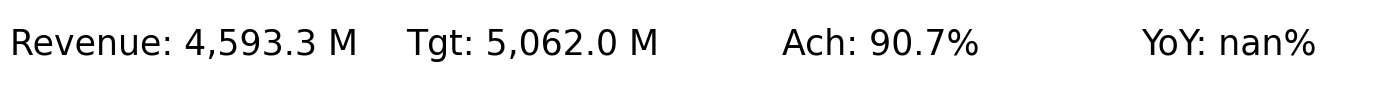

In [127]:
''' Yearly Revenue '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Revenue: {format(unit_mb(ytd_act),',.1f')} M", size=25, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(unit_mb(ytd_tgt),',.1f')} M", size=25, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(ytd_achv,',.1%')}", size=25, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"YoY: {format(ytd_yoy,',.1%')}", size=25, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

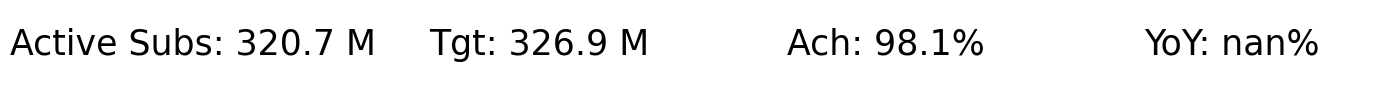

In [132]:
''' Yearly Active Subs '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Active Subs: {format(unit_mb(ytd_act_actv_sub),',.1f')} M", size=25, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(unit_mb(ytd_tgt_actv_sub),',.1f')} M", size=25, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(ytd_achv_actv_sub,',.1%')}", size=25, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"YoY: {format(ytd_yoy_actv_sub,',.1%')}", size=25, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

In [60]:
# ''' Yearly Summary '''

# fig = plt.figure(figsize=(14, 2))
# gs = GridSpec(2, 4)

# ''' Revenue '''
# ax1 = fig.add_subplot(gs[0, 0])
# ax2 = fig.add_subplot(gs[0, 1])
# ax3 = fig.add_subplot(gs[0, 2])
# ax4 = fig.add_subplot(gs[0, 3])

# ax1.text(0.5, 0.5, f"Act: {format(ytd_act,',.1f')} M", size=25, ha='center', va='center')
# ax1.spines[['top','left','right','bottom']].set_visible(False)
# ax1.set_axis_off()

# ax2.text(0.5, 0.5, f"Tgt: {format(ytd_tgt,',.1f')} M", size=25, ha='center', va='center')
# ax2.spines[['top','left','right','bottom']].set_visible(False)
# ax2.set_axis_off()

# ax3.text(0.5, 0.5, f"Ach: {format(ytd_achv,',.1%')}", size=25, ha='center', va='center')
# ax3.spines[['top','left','right','bottom']].set_visible(False)
# ax3.set_axis_off()

# ax4.text(0.5, 0.5, f"YoY: {format(ytd_yoy,',.1%')}", size=25, ha='center', va='center')
# ax4.spines[['top','left','right','bottom']].set_visible(False)
# ax4.set_axis_off()

# ''' Subs '''
# ax5 = fig.add_subplot(gs[1, 0])
# ax6 = fig.add_subplot(gs[1, 1])
# ax7 = fig.add_subplot(gs[1, 2])
# ax8 = fig.add_subplot(gs[1, 3])

# ax5.text(0.5, 0.5, f"Act: {format(ytd_act_actv_sub,',.1f')} M", size=25, ha='center', va='center')
# ax5.spines[['top','left','right','bottom']].set_visible(False)
# ax5.set_axis_off()

# ax6.text(0.5, 0.5, f"Tgt: {format(ytd_tgt_actv_sub,',.1f')} M", size=25, ha='center', va='center')
# ax6.spines[['top','left','right','bottom']].set_visible(False)
# ax6.set_axis_off()

# ax7.text(0.5, 0.5, f"Ach: {format(ytd_achv_actv_sub,',.1%')}", size=25, ha='center', va='center')
# ax7.spines[['top','left','right','bottom']].set_visible(False)
# ax7.set_axis_off()

# ax8.text(0.5, 0.5, f"YoY: {format(ytd_yoy_actv_sub,',.1%')}", size=25, ha='center', va='center')
# ax8.spines[['top','left','right','bottom']].set_visible(False)
# ax8.set_axis_off()

# fig.tight_layout()
# plt.show()

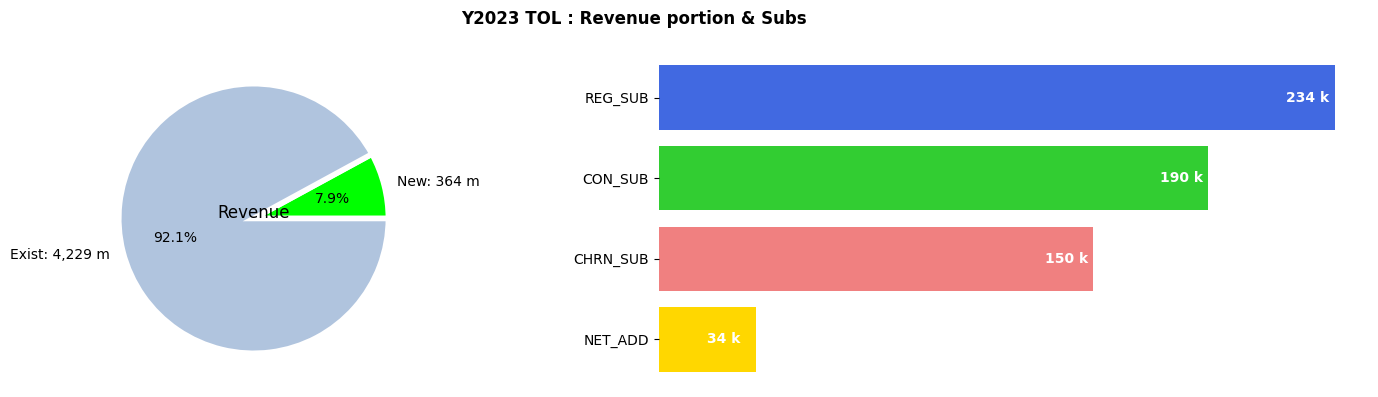

In [113]:
'''' Revenue Portion & Subscription Chart '''

fig = plt.figure(figsize=(15, 4))
fig.suptitle(f'Y{curr_yr} TOL : Revenue portion & Subs', weight='bold')
gs = GridSpec(1, 2)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])

''' ax1 '''
y = np.array([unit_mb(y_yr_act_new.sum()), unit_mb(y_yr_act_exist.sum())])
mylabels = [f"New: {format(y[0],',.0f')} m", f"Exist: {format(y[1],',.0f')} m"]
mycolors = ["lime", "lightsteelblue"]
ax1.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax1.text(0, 0, 'Revenue', ha='center', fontsize=12)

''' ax2 '''
bars = ax2.barh(df_bar_h['METRIC_NAME'], width=df_bar_h['VALUES']/1000, color=df_bar_h['COLOR'])
ax2.bar_label(bars, label_type='edge', padding=-35, color='white', fontweight='bold', fmt='%.0f k')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2 = plt.gca()
ax2.get_xaxis().set_visible(False)
# ax2.get_yaxis().set_visible(False)

fig.tight_layout()
plt.show()

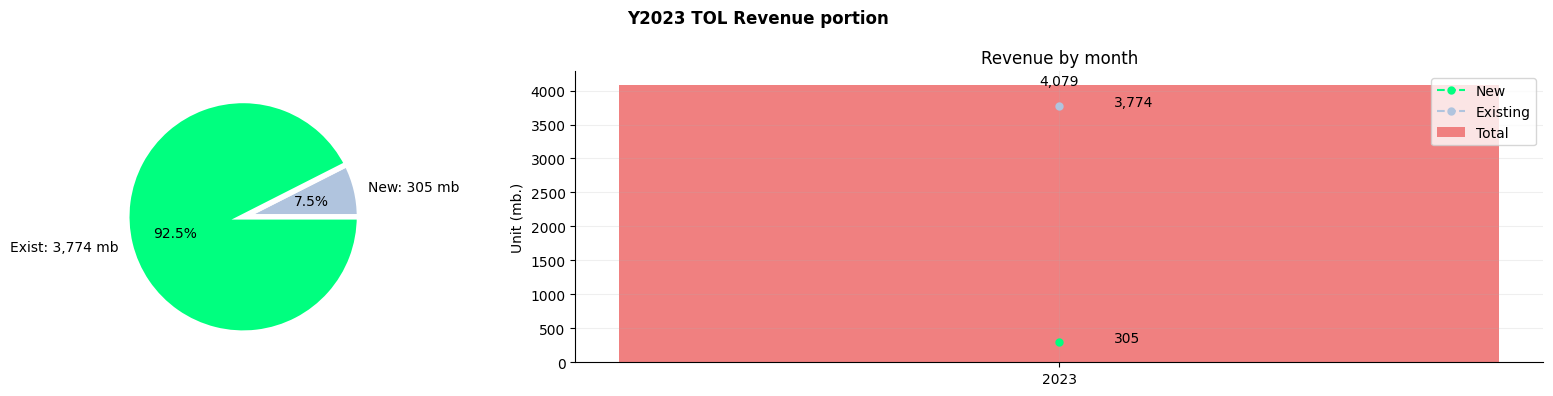

In [66]:
'''' Revenue Portion Chart '''

fig = plt.figure(figsize=(16, 4))
fig.suptitle(f'Y{curr_yr} TOL Revenue portion', weight='bold')
gs = GridSpec(1, 3)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1:])

''' ax1 '''
y = np.array([y_yr_act_new.sum(), y_yr_act_exist.sum()])
mylabels = [f"New: {format(y[0],',.0f')} mb", f"Exist: {format(y[1],',.0f')} mb"]
mycolors = ["lightsteelblue", "springgreen"]
ax1.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
# ax1.text(0, 0, 'Total', ha='center', fontsize=14)

''' ax2 '''
ax2.set_title('Revenue by month')
ax2.bar(x_yr_axis, y_yr_act, label='Total', color='lightcoral')
ax2.plot(x_yr_axis, y_yr_act_new, marker='.', linestyle='dashed', markeredgewidth=3, label='New', color='springgreen')
ax2.plot(x_yr_axis, y_yr_act_exist, marker='.', linestyle='dashed', markeredgewidth=3, label='Existing', color='lightsteelblue')
for i in x_yr_axis:
    ax2.annotate(str(format(y_yr_act[i],',.0f')), xy=(x_yr_axis[i], y_yr_act[i]), ha='center')
    ax2.annotate(str(format(y_yr_act_new[i],',.0f')), xy=(x_yr_axis[i]+0.05, y_yr_act_new[i]))
    ax2.annotate(str(format(y_yr_act_exist[i],',.0f')), xy=(x_yr_axis[i]+0.05, y_yr_act_exist[i]))
ax2.set_xticks(x_yr_axis, x_yr)
ax2.set_ylabel('Unit (mb.)', fontsize=10)
ax2.grid(alpha=0.2)
ax2.legend()

fig.tight_layout()
plt.show()

## ** Monthly

### MTH : Aggregation

In [71]:
''' Create Dataframe '''

df_agg_s_mth = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_MTH', 'MTH_DESC', 'AGG_TYPE']).agg({'ACT': 'sum', 'TGT': 'sum'}).reset_index()
df_agg_n_mth = df_agg_n.loc[df_agg_n.groupby('TM_KEY_MTH')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_MTH', 'MTH_DESC', 'AGG_TYPE', 'ACT', 'TGT']]
df_rev_mth = pd.concat([df_agg_s_mth, df_agg_n_mth])

''' Aggregation '''
df_rev_mth['%ACHV'] = df_rev_mth['ACT'] / df_rev_mth['TGT']
df_rev_mth['GAP'] = df_rev_mth['ACT'] - df_rev_mth['TGT']
df_rev_mth['LAST_ACT'] = df_rev_mth.groupby('METRIC_CD')['ACT'].shift()
df_rev_mth['DIFF'] = df_rev_mth['ACT'] - df_rev_mth['LAST_ACT']
df_rev_mth['%MOM'] = (df_rev_mth['ACT'] / df_rev_mth['LAST_ACT']) - 1

df_rev_mth.tail(3)

,METRIC_CD,METRIC_NAME,TM_KEY_MTH,MTH_DESC,AGG_TYPE,ACT,TGT,%ACHV,GAP,LAST_ACT,DIFF,%MOM
45092,TB3S000500,TOL Active Subs,202304,April,N,3.057351,3.124065,0.978645,-0.066714,3.059512,-0.002161,-0.000706
45123,TB3S000500,TOL Active Subs,202305,May,N,3.051428,3.165210,0.964052,-0.113782,3.057351,-0.005923,-0.001937
45135,TB3S000500,TOL Active Subs,202306,June,N,3.050765,3.181668,0.958857,-0.130903,3.051428,-0.000663,-0.000217


In [72]:
''' Pivot by KPIS '''

df_rev_mth_agg = df_rev_mth.pivot(index=['TM_KEY_MTH', 'MTH_DESC'], columns='METRIC_NAME', 
                                  values=['ACT', 'TGT', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%MOM']).rename(columns=cols_dict).reset_index()
df_rev_mth_agg.tail(3)

TM_KEY_MTH MTH_DESC       ACT                                   \
METRIC_NAME                      ACTV_SUB  CHRN_SUB   CON_SUB        EXIST   
1               202304    April  3.057351  0.046117  0.052240  1301.262169   
2               202305      May  3.051428  0.044845  0.056476  1151.590035   
3               202306     June  3.050765  0.012277  0.019488     0.000000   

                                                          ...      DIFF  \
METRIC_NAME   NET_ADD         NEW   REG_SUB        TOTAL  ...   REG_SUB   
1            0.006123  104.253538  0.065935  1405.515708  ... -0.008594   
2            0.011631  120.711285  0.068410  1272.301320  ...  0.002475   
3            0.002401    0.000000  0.023534     0.000000  ... -0.044876   

                              %MOM                                          \
METRIC_NAME        TOTAL  ACTV_SUB  CHRN_SUB   CON_SUB     EXIST   NET_ADD   
1               4.112948 -0.000706 -0.023876 -0.139487 -0.015364 -0.545198   
2            -133.214387 -0.001937 -0.027582  0.081087 -0.115021  0.899559   
3           -1272.301320 -0.000217 -0.726235 -0.654933 -1.000000 -0.793569   

                                           
METRIC_NAME       NEW   REG_SUB     TOTAL  
1            0.305852 -0.115311  0.002935  
2            0.157863  0.037537 -0.094780  
3           -1.000000 -0.655986 -1.000000  

[3 rows x 58 columns]

In [74]:
''' Month to Date Values '''

df_last_mth = df_rev_day_agg[df_rev_day_agg['TM_KEY_MTH']==last_mth][['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'ACT', 'TGT']]
day_cnt_curr_mth = len(df_rev_day_agg[(df_rev_day_agg['TM_KEY_MTH']==curr_mth) & (df_rev_day_agg['ACT']['TOTAL']>0)]['TM_KEY_DAY'].unique())

''' Revenue '''
mtd_last_act = (df_last_mth['ACT']['TOTAL'].sum() / len(df_last_mth['TM_KEY_DAY'].unique())) * day_cnt_curr_mth
mtd_act = df_rev_day_agg[df_rev_day_agg['TM_KEY_MTH']==curr_mth]['ACT']['TOTAL'].sum()
mtd_tgt = df_rev_day_agg[df_rev_day_agg['TM_KEY_MTH']==curr_mth]['TGT']['TOTAL'].sum()
mtd_achv = mtd_act / mtd_tgt
mtd_mom = (mtd_act / mtd_last_act) - 1
mtd_act_gap = mtd_act - mtd_last_act

''' Subs '''
mtd_last_act_actv_sub = (df_last_mth['ACT']['ACTV_SUB'].sum() / len(df_last_mth['TM_KEY_DAY'].unique())) * day_cnt_curr_mth
mtd_act_actv_sub = df_rev_day_agg[df_rev_day_agg['TM_KEY_MTH']==curr_mth]['ACT']['ACTV_SUB'].sum()
mtd_tgt_actv_sub = df_rev_day_agg[df_rev_day_agg['TM_KEY_MTH']==curr_mth]['TGT']['ACTV_SUB'].sum()
mtd_achv_actv_sub = mtd_act_actv_sub / mtd_tgt_actv_sub
mtd_mom_actv_sub = (mtd_act_actv_sub / mtd_last_act_actv_sub) - 1
mtd_act_gap_actv_sub = mtd_act_actv_sub - mtd_last_act_actv_sub

C:\Users\Narut4\AppData\Local\Temp\ipykernel_6332\3784869136.py:10: RuntimeWarning: invalid value encountered in scalar divide
  mtd_achv = mtd_act / mtd_tgt
C:\Users\Narut4\AppData\Local\Temp\ipykernel_6332\3784869136.py:11: RuntimeWarning: invalid value encountered in scalar divide
  mtd_mom = (mtd_act / mtd_last_act) - 1
C:\Users\Narut4\AppData\Local\Temp\ipykernel_6332\3784869136.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  mtd_mom_actv_sub = (mtd_act_actv_sub / mtd_last_act_actv_sub) - 1


In [75]:
''' Month Chart Values '''

x_mth = df_rev_mth_agg['MTH_DESC']
x_mth_axis = np.arange(len(x_mth))

''' TOTAL : Values '''
y_mth_act = df_rev_mth_agg['ACT']['TOTAL']
y_mth_tgt = df_rev_mth_agg['TGT']['TOTAL']
y_mth_achv = df_rev_mth_agg['%ACHV']['TOTAL']
y_mth_gap = df_rev_mth_agg['GAP']['TOTAL']
y_mth_diff = df_rev_mth_agg['DIFF']['TOTAL']
y_mth_last_act = df_rev_mth_agg['LAST_ACT']['TOTAL']
y_mth_mom = df_rev_mth_agg['%MOM']['TOTAL']

''' NEW : Values '''
y_mth_act_new = df_rev_mth_agg['ACT']['NEW']
y_mth_tgt_new = df_rev_mth_agg['TGT']['NEW']
y_mth_achv_new = df_rev_mth_agg['%ACHV']['NEW']
y_mth_gap_new = df_rev_mth_agg['GAP']['NEW']
y_mth_diff_new = df_rev_mth_agg['DIFF']['NEW']
y_mth_last_act_new = df_rev_mth_agg['LAST_ACT']['NEW']
y_mth_mom_new = df_rev_mth_agg['%MOM']['NEW']

''' EXIST : Values '''
y_mth_act_exist = df_rev_mth_agg['ACT']['EXIST']
y_mth_tgt_exist = df_rev_mth_agg['TGT']['EXIST']
y_mth_achv_exist = df_rev_mth_agg['%ACHV']['EXIST']
y_mth_gap_exist = df_rev_mth_agg['GAP']['EXIST']
y_mth_diff_exist = df_rev_mth_agg['DIFF']['EXIST']
y_mth_last_act_exist = df_rev_mth_agg['LAST_ACT']['EXIST']
y_mth_mom_exist = df_rev_mth_agg['%MOM']['EXIST']

''' ACTV_SUB : Values '''
y_mth_act_actv_sub = df_rev_mth_agg['ACT']['ACTV_SUB']
y_mth_tgt_actv_sub = df_rev_mth_agg['TGT']['ACTV_SUB']
y_mth_achv_actv_sub = df_rev_mth_agg['%ACHV']['ACTV_SUB']
y_mth_gap_actv_sub = df_rev_mth_agg['GAP']['ACTV_SUB']
y_mth_diff_actv_sub = df_rev_mth_agg['DIFF']['ACTV_SUB']
y_mth_last_act_actv_sub = df_rev_mth_agg['LAST_ACT']['ACTV_SUB']
y_mth_mom_actv_sub = df_rev_mth_agg['%MOM']['ACTV_SUB']

''' CON_SUB : Values '''
y_mth_act_con_sub = df_rev_mth_agg['ACT']['CON_SUB']
y_mth_tgt_con_sub = df_rev_mth_agg['TGT']['CON_SUB']
y_mth_achv_con_sub = df_rev_mth_agg['%ACHV']['CON_SUB']
y_mth_gap_con_sub = df_rev_mth_agg['GAP']['CON_SUB']
y_mth_diff_con_sub = df_rev_mth_agg['DIFF']['CON_SUB']
y_mth_last_act_con_sub = df_rev_mth_agg['LAST_ACT']['CON_SUB']
y_mth_mom_con_sub = df_rev_mth_agg['%MOM']['CON_SUB']

''' REG_SUB : Values '''
y_mth_act_reg_sub = df_rev_mth_agg['ACT']['REG_SUB']
y_mth_tgt_reg_sub = df_rev_mth_agg['TGT']['REG_SUB']
y_mth_achv_reg_sub = df_rev_mth_agg['%ACHV']['REG_SUB']
y_mth_gap_reg_sub = df_rev_mth_agg['GAP']['REG_SUB']
y_mth_diff_reg_sub = df_rev_mth_agg['DIFF']['REG_SUB']
y_mth_last_act_reg_sub = df_rev_mth_agg['LAST_ACT']['REG_SUB']
y_mth_mom_reg_sub = df_rev_mth_agg['%MOM']['REG_SUB']

''' CHRN_SUB : Values '''
y_mth_act_chrn_sub = df_rev_mth_agg['ACT']['CHRN_SUB']
y_mth_tgt_chrn_sub = df_rev_mth_agg['TGT']['CHRN_SUB']
y_mth_achv_chrn_sub = df_rev_mth_agg['%ACHV']['CHRN_SUB']
y_mth_gap_chrn_sub = df_rev_mth_agg['GAP']['CHRN_SUB']
y_mth_diff_chrn_sub = df_rev_mth_agg['DIFF']['CHRN_SUB']
y_mth_last_act_chrn_sub = df_rev_mth_agg['LAST_ACT']['CHRN_SUB']
y_mth_mom_chrn_sub = df_rev_mth_agg['%MOM']['CHRN_SUB']

''' NET_ADD : Values '''
y_mth_act_net_add = df_rev_mth_agg['ACT']['NET_ADD']
y_mth_tgt_net_add = df_rev_mth_agg['TGT']['NET_ADD']
y_mth_achv_net_add = df_rev_mth_agg['%ACHV']['NET_ADD']
y_mth_gap_net_add = df_rev_mth_agg['GAP']['NET_ADD']
y_mth_diff_net_add = df_rev_mth_agg['DIFF']['NET_ADD']
y_mth_last_act_net_add = df_rev_mth_agg['LAST_ACT']['NET_ADD']
y_mth_mom_net_add = df_rev_mth_agg['%MOM']['NET_ADD']

### MTH : TOL Revenue Summary

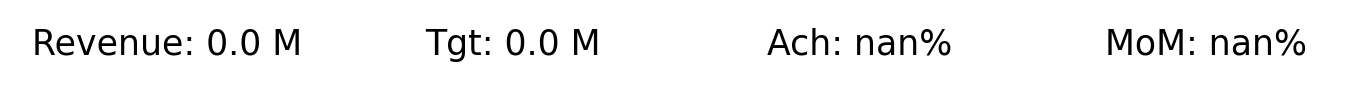

In [77]:
''' Monthly Revenue '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Revenue: {format(mtd_act,',.1f')} M", size=25, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(mtd_tgt,',.1f')} M", size=25, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(mtd_achv,',.1%')}", size=25, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"MoM: {format(mtd_mom,',.1%')}", size=25, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

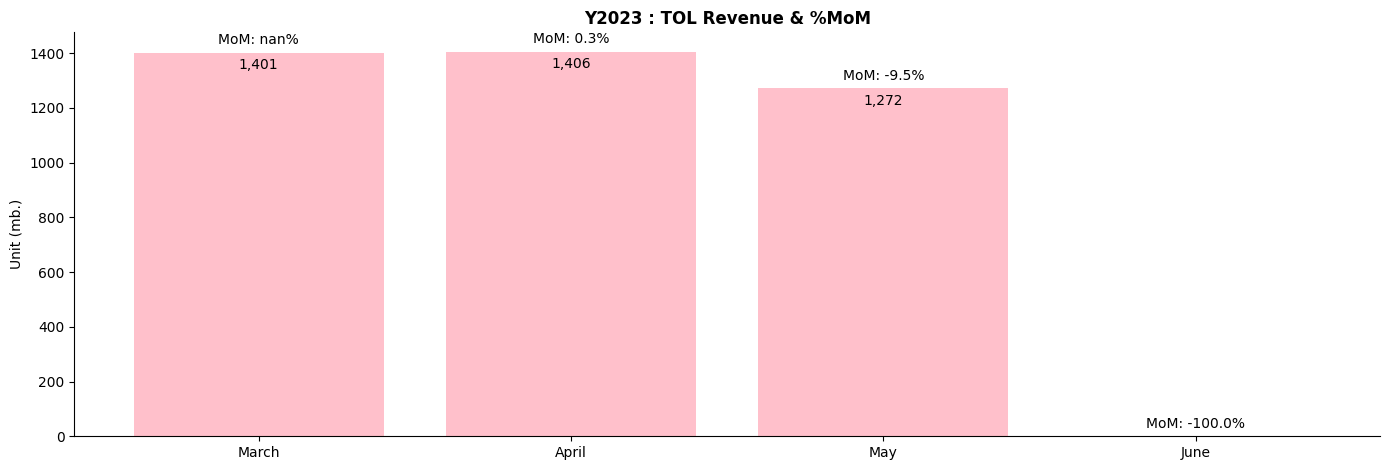

In [83]:
''' Revenue & MoM : MTH Chart '''

plt.figure().set_figwidth(14)

plt.title(f"Y{curr_yr} : TOL Revenue & %MoM", weight='bold')
plt.bar(x_mth_axis, y_mth_act, label='Total', color='pink')
for i in x_mth_axis:
    plt.annotate(f"MoM: {format(y_mth_mom[i],',.1%')}", xy=(x_mth_axis[i], y_mth_act[i]+20), ha='center', va='bottom')
    plt.annotate(format(y_mth_act[i],',.0f'), xy=(x_mth_axis[i], y_mth_act[i]-20), ha='center', va='top')

plt.ylabel('Unit (mb.)')
plt.xticks(x_mth_axis, x_mth)
plt.tight_layout()
plt.show()

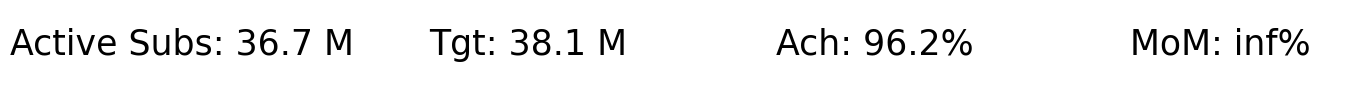

In [79]:
''' Monthly Active Subs '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Active Subs: {format(mtd_act_actv_sub,',.1f')} M", size=25, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(mtd_tgt_actv_sub,',.1f')} M", size=25, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(mtd_achv_actv_sub,',.1%')}", size=25, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"MoM: {format(mtd_mom_actv_sub,',.1%')}", size=25, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

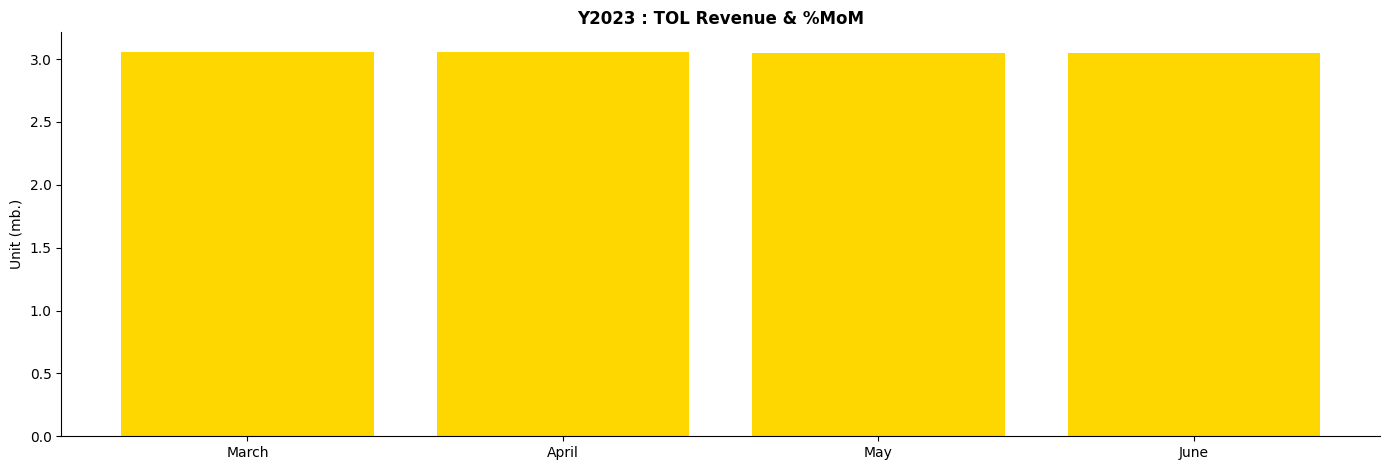

In [84]:
''' Active Subs & MoM : MTH Chart '''

plt.figure().set_figwidth(14)

plt.title(f"Y{curr_yr} : TOL Revenue & %MoM", weight='bold')
plt.bar(x_mth_axis, y_mth_act_actv_sub, label='Total', color='gold')
for i in x_mth_axis:
    plt.annotate(f"MoM: {format(y_mth_mom_actv_sub[i],',.1%')}", xy=(x_mth_axis[i], y_mth_act_actv_sub[i]+20), ha='center', va='bottom')
    plt.annotate(format(y_mth_act_actv_sub[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_actv_sub[i]-20), ha='center', va='top')

plt.ylabel('Unit (mb.)')
plt.xticks(x_mth_axis, x_mth)
plt.tight_layout()
plt.show()

NameError: name 'y_mth_act_tmh' is not defined

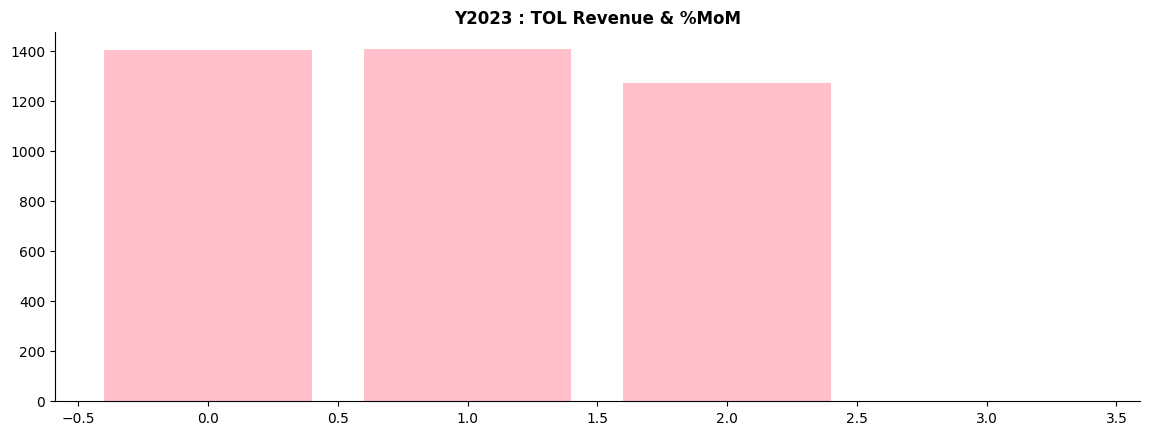

In [81]:
''' Revenue & MoM : MTH Chart '''

plt.figure().set_figwidth(14)

plt.title(f"Y{curr_yr} : TOL Revenue & %MoM", weight='bold')
plt.bar(x_mth_axis, y_mth_act, label='Total', color='pink')
plt.plot(x_mth_axis, y_mth_act_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='TMH', color='orangered')
plt.plot(x_mth_axis, y_mth_act_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC', color='dodgerblue')
for i in x_mth_axis:
    plt.annotate(f"MoM: {format(y_mth_mom[i],',.1%')}", xy=(x_mth_axis[i], y_mth_act[i]+20), ha='center', va='bottom')
    plt.annotate(format(y_mth_act[i],',.0f'), xy=(x_mth_axis[i], y_mth_act[i]-20), ha='center', va='top')
    plt.annotate(f"{format(y_mth_mom_tmh[i],',.1%')}", xy=(x_mth_axis[i], y_mth_act_tmh[i]+20), ha='center', va='bottom', fontsize=9)
    plt.annotate(format(y_mth_act_tmh[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_tmh[i]-20), ha='center', va='top', fontsize=9)
    plt.annotate(f"{format(y_mth_mom_dtac[i],',.1%')}", xy=(x_mth_axis[i], y_mth_act_dtac[i]+20), ha='center', va='bottom', fontsize=9)
    plt.annotate(format(y_mth_act_dtac[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_dtac[i]-20), ha='center', va='top', fontsize=9)
    
plt.ylabel('Unit (mb.)')
plt.xticks(x_mth_axis, x_mth)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
''' Revenue with New & Existing : MTH Chart '''

plt.figure().set_figwidth(14)

width = 0.3
diff_loc = 0.3

plt.title(f'Y{curr_yr} Postpaid Revenue by month(New & Existing)', fontdict={'fontweight': 'bold'})
plt.bar(x_mth_axis-diff_loc, y_mth_act_exist, width, label='Exist', color='pink')
plt.bar(x_mth_axis-diff_loc, y_mth_act_new, width, label='New', color='hotpink', bottom=y_mth_act_exist)
plt.bar(x_mth_axis, y_mth_act_exist_tmh, width, label='TMH: Exist', color='lightsalmon')
plt.bar(x_mth_axis, y_mth_act_new_tmh, width, label='TMH: New', color='orangered', bottom=y_mth_act_exist_tmh)
plt.bar(x_mth_axis+diff_loc, y_mth_act_exist_dtac, width, label='DTAC: Exist', color='lightskyblue')
plt.bar(x_mth_axis+diff_loc, y_mth_act_new_dtac, width, label='DTAC: New', color='dodgerblue', bottom=y_mth_act_exist_dtac)
for i in x_mth_axis:    
    plt.annotate(format(y_mth_act_exist[i],',.0f'), xy=(x_mth_axis[i]-diff_loc, y_mth_act_exist[i]-300), ha='center', fontsize=9)
    plt.annotate(format(y_mth_act_new[i],',.0f'), xy=(x_mth_axis[i]-diff_loc, y_mth_act_exist[i]+100), ha='center', fontsize=9)
    plt.annotate(format(y_mth_act_exist_tmh[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_exist_tmh[i]-300), ha='center', fontsize=9)
    plt.annotate(format(y_mth_act_new_tmh[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_exist_tmh[i]+100), ha='center', fontsize=9)
    plt.annotate(format(y_mth_act_exist_dtac[i],',.0f'), xy=(x_mth_axis[i]+diff_loc, y_mth_act_exist_dtac[i]-300), ha='center', fontsize=9)
    plt.annotate(format(y_mth_act_new_dtac[i],',.0f'), xy=(x_mth_axis[i]+diff_loc, y_mth_act_exist_dtac[i]+100), ha='center', fontsize=9)

plt.ylabel('Unit (mb.)')
plt.xticks(x_mth_axis, x_mth)
plt.legend()
plt.tight_layout()
plt.show()

### MTH : Postpaid Revenue : TMH vs DTAC

In [ ]:
''' Revenue portion of New/Existing : TMH vs DTAC : MTH Chart '''

fig = plt.figure(figsize=(12, 4))
fig.suptitle(f'Y{curr_yr} Postpaid Revenue portion of New/Existing : TMH vs DTAC', weight='bold')
gs = GridSpec(1, 2)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])

''' ax1 '''
y = np.array([sum(y_mth_act_new_tmh), sum(y_mth_act_exist_tmh)])
mylabels = [f"New: {format(y[0],',.0f')} mb", f"Exist: {format(y[1],',.0f')} mb"]
mycolors = ["orangered", "lightsalmon"]
ax1.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax1.text(0, 0, 'TMH', ha='center', fontsize=14)

''' ax2 '''
y = np.array([sum(y_mth_act_new_dtac), sum(y_mth_act_exist_dtac)])
mylabels = [f"New: {format(y[0],',.0f')} mb", f"Exist: {format(y[1],',.0f')} mb"]
mycolors = ["dodgerblue", "lightskyblue"]
ax2.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax2.text(0, 0, 'DTAC', ha='center', fontsize=14)

fig.tight_layout()
plt.show()

In [ ]:
''' Revenue : TMH vs DTAC : MTH Chart '''

fig = plt.figure(figsize=(14, 7))
fig.suptitle(f'Y{curr_yr} Postpaid Revenue : TMH vs DTAC by month', weight='bold')
gs = GridSpec(3, 4)
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[2, 0])
ax3 = fig.add_subplot(gs[0, :])
ax4 = fig.add_subplot(gs[1, 1:])
ax5 = fig.add_subplot(gs[2, 1:])

''' ax1 '''
y = np.array([sum(y_mth_act_new_tmh), sum(y_mth_act_new_dtac)])
mylabels = [f"TMH: {format(y[0],',.0f')} mb", f"DTAC: {format(y[1],',.0f')} mb"]
mycolors = ["orangered", "dodgerblue"]
ax1.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax1.set_ylabel('New', weight='bold')

''' ax2 '''
y = np.array([sum(y_mth_act_exist_tmh), sum(y_mth_act_exist_dtac)])
mylabels = [f"TMH: {format(y[0],',.0f')} mb", f"DTAC: {format(y[1],',.0f')} mb"]
mycolors = ["lightsalmon", "lightskyblue"]
ax2.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax2.set_ylabel('Existing', weight='bold')

''' ax3 '''
ax3.plot(x_mth_axis, y_mth_act_tmh, marker='.', markeredgewidth=3, label='TMH', color='orangered')
ax3.plot(x_mth_axis, y_mth_act_dtac, marker='.', markeredgewidth=3, label='DTAC', color='dodgerblue')
ax3.legend()
ax3.grid(alpha=0.3)
ax3.set_xticks(x_mth_axis, x_mth)
ax3.spines[['top', 'right']].set_visible(False)
for i in x_mth_axis:
    ax3.annotate(format(y_mth_act_tmh[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_tmh[i]), ha='center', va='bottom', fontsize=9)
    ax3.annotate(format(y_mth_act_dtac[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_dtac[i]), ha='center', va='bottom', fontsize=9)

''' ax4 '''
ax4.plot(x_mth_axis, y_mth_act_new_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='TMH: New', color='orangered')
ax4.plot(x_mth_axis, y_mth_act_new_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC: New', color='dodgerblue')
ax4.legend()
ax4.grid(alpha=0.3)
ax4.set_xticks(x_mth_axis, x_mth)
ax4.spines[['top', 'right', 'left']].set_visible(False)
for i in x_mth_axis:
    ax4.annotate(format(y_mth_act_new_tmh[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_new_tmh[i]), ha='center', va='bottom', fontsize=9)
    ax4.annotate(format(y_mth_act_new_dtac[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_new_dtac[i]), ha='center', va='bottom', fontsize=9)

''' ax5 '''
ax5.plot(x_mth_axis, y_mth_act_exist_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='TMH: Exist', color='orangered')
ax5.plot(x_mth_axis, y_mth_act_exist_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC: Exist', color='dodgerblue')
ax5.legend()
ax5.grid(alpha=0.3)
ax5.set_xticks(x_mth_axis, x_mth)
ax5.spines[['top', 'right', 'left']].set_visible(False)
for i in x_mth_axis:
    ax5.annotate(format(y_mth_act_exist_tmh[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_exist_tmh[i]), ha='center', va='bottom', fontsize=9)
    ax5.annotate(format(y_mth_act_exist_dtac[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_exist_dtac[i]), ha='center', va='bottom', fontsize=9)

fig.tight_layout()
plt.show()

### MTH : Postpaid Performance : %Achievement & Gap

In [ ]:
''' Peformance : %Achievement & Gap : MTH Chart '''

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(14, 8))
fig.suptitle(f"Y{curr_yr} Postpaid : Performance by month : %Achievement & Gap\n\n \
    ALL: {format(sum(y_mth_act)/sum(y_mth_tgt),',.1%')}({format(sum(y_mth_gap),',.0f')}) \
        TMH: {format(sum(y_mth_act_tmh)/sum(y_mth_tgt_tmh),',.1%')}({format(sum(y_mth_gap_tmh),',.0f')}) \
            DTAC: {format(sum(y_mth_act_dtac)/sum(y_mth_tgt_dtac),',.1%')}({format(sum(y_mth_gap_dtac),',.0f')})", weight='bold')

''' ax1 '''
ax1.plot(x_mth_axis, y_mth_tgt, marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='gold')
ax1.plot(x_mth_axis, y_mth_act, marker='.', markeredgewidth=3, label='Actual', color='pink')
ax1.plot(x_mth_axis, y_mth_last_act, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH', color='darkgray')
ax1.legend()
ax1.grid(alpha=0.2)
for i in x_mth_axis:
    ax1.annotate(format(y_mth_achv[i],',.1%'), xy=(x_mth_axis[i], y_mth_act[i]+1), ha='center', va='bottom')
    ax1.annotate(format(y_mth_gap[i],',.0f'), xy=(x_mth_axis[i], y_mth_act[i]-2), ha='center', va='top')

''' ax2 '''
ax2.plot(x_mth_axis, y_mth_tgt_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Target: TMH', color='gold')
ax2.plot(x_mth_axis, y_mth_act_tmh, marker='.', markeredgewidth=3, label='Actual: TMH', color='orangered')
ax2.plot(x_mth_axis, y_mth_last_act_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH: TMH', color='darkgray')
ax2.legend()
ax2.grid(alpha=0.2)
for i in x_mth_axis:
    ax2.annotate(format(y_mth_achv_tmh[i],',.1%'), xy=(x_mth_axis[i], y_mth_act_tmh[i]+1), ha='center', va='bottom')
    ax2.annotate(format(y_mth_gap_tmh[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_tmh[i]-2), ha='center', va='top')

''' ax3 '''
ax3.plot(x_mth_axis, y_mth_tgt_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Target: DTAC', color='gold')
ax3.plot(x_mth_axis, y_mth_act_dtac, marker='.', markeredgewidth=3, label='Actual: DTAC', color='dodgerblue')
ax3.plot(x_mth_axis, y_mth_last_act_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH: DTAC', color='darkgray')
ax3.legend()
ax3.grid(alpha=0.2)
for i in x_mth_axis:
    ax3.annotate(format(y_mth_achv_dtac[i],',.1%'), xy=(x_mth_axis[i], y_mth_act_dtac[i]+1), ha='center', va='bottom')
    ax3.annotate(format(y_mth_gap_dtac[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_dtac[i]-2), ha='center', va='top')

fig.supylabel('Unit (mb.)', fontsize=10)
fig.tight_layout()
plt.xticks(x_mth_axis, x_mth)
plt.show()

In [ ]:
''' NEW : Peformance : %Achievement & Gap : MTH Chart '''

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(14, 7))
fig.suptitle(f'Y{curr_yr} Postpaid NEW : Performance by month : %Achievement & Gap', weight='bold')

''' ax1 '''
ax1.plot(x_mth_axis, y_mth_tgt_new, marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='gold')
ax1.plot(x_mth_axis, y_mth_act_new, marker='.', markeredgewidth=3, label='Actual', color='pink')
ax1.plot(x_mth_axis, y_mth_last_act_new, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH', color='darkgray')
ax1.legend()
ax1.grid(alpha=0.2)
for i in x_mth_axis:
    ax1.annotate(format(y_mth_achv_new[i],',.1%'), xy=(x_mth_axis[i], y_mth_act_new[i]+1), ha='center', va='bottom')
    ax1.annotate(format(y_mth_gap_new[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_new[i]-2), ha='center', va='top')

''' ax2 '''
ax2.plot(x_mth_axis, y_mth_tgt_new_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Target: TMH', color='gold')
ax2.plot(x_mth_axis, y_mth_act_new_tmh, marker='.', markeredgewidth=3, label='Actual: TMH', color='orangered')
ax2.plot(x_mth_axis, y_mth_last_act_new_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH: TMH', color='darkgray')
ax2.legend()
ax2.grid(alpha=0.2)
for i in x_mth_axis:
    ax2.annotate(format(y_mth_achv_new_tmh[i],',.1%'), xy=(x_mth_axis[i], y_mth_act_new_tmh[i]+1), ha='center', va='bottom')
    ax2.annotate(format(y_mth_gap_new_tmh[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_new_tmh[i]-2), ha='center', va='top')

''' ax3 '''
ax3.plot(x_mth_axis, y_mth_tgt_new_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Target: DTAC', color='gold')
ax3.plot(x_mth_axis, y_mth_act_new_dtac, marker='.', markeredgewidth=3, label='Actual: DTAC', color='dodgerblue')
ax3.plot(x_mth_axis, y_mth_last_act_new_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH: DTAC', color='darkgray')
ax3.legend()
ax3.grid(alpha=0.2)
for i in x_mth_axis:
    ax3.annotate(format(y_mth_achv_new_dtac[i],',.1%'), xy=(x_mth_axis[i], y_mth_act_new_dtac[i]+1), ha='center', va='bottom')
    ax3.annotate(format(y_mth_gap_new_dtac[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_new_dtac[i]-2), ha='center', va='top')

fig.supylabel('Unit (mb.)', fontsize=10)
fig.tight_layout()
plt.xticks(x_mth_axis, x_mth)
plt.show()

In [ ]:
''' EXISTING : Peformance : %Achievement & Gap : MTH Chart '''

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(14, 7))
fig.suptitle(f'Y{curr_yr} Postpaid EXISTING : Performance by month : %Achievement & Gap', weight='bold')

''' ax1 '''
ax1.plot(x_mth_axis, y_mth_tgt_exist, marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='gold')
ax1.plot(x_mth_axis, y_mth_act_exist, marker='.', markeredgewidth=3, label='Actual', color='pink')
ax1.plot(x_mth_axis, y_mth_last_act_exist, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH', color='darkgray')
ax1.legend()
ax1.grid(alpha=0.2)
for i in x_mth_axis:
    ax1.annotate(format(y_mth_achv_exist[i],',.1%'), xy=(x_mth_axis[i], y_mth_act_exist[i]+1), ha='center', va='bottom')
    ax1.annotate(format(y_mth_gap_exist[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_exist[i]-2), ha='center', va='top')

''' ax2 '''
ax2.plot(x_mth_axis, y_mth_tgt_exist_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Target: TMH', color='gold')
ax2.plot(x_mth_axis, y_mth_act_exist_tmh, marker='.', markeredgewidth=3, label='Actual: TMH', color='orangered')
ax2.plot(x_mth_axis, y_mth_last_act_exist_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH: TMH', color='darkgray')
ax2.legend()
ax2.grid(alpha=0.2)
for i in x_mth_axis:
    ax2.annotate(format(y_mth_achv_exist_tmh[i],',.1%'), xy=(x_mth_axis[i], y_mth_act_exist_tmh[i]+1), ha='center', va='bottom')
    ax2.annotate(format(y_mth_gap_exist_tmh[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_exist_tmh[i]-2), ha='center', va='top')

''' ax3 '''
ax3.plot(x_mth_axis, y_mth_tgt_exist_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Target: DTAC', color='gold')
ax3.plot(x_mth_axis, y_mth_act_exist_dtac, marker='.', markeredgewidth=3, label='Actual: DTAC', color='dodgerblue')
ax3.plot(x_mth_axis, y_mth_last_act_exist_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH: DTAC', color='darkgray')
ax3.legend()
ax3.grid(alpha=0.2)
for i in x_mth_axis:
    ax3.annotate(format(y_mth_achv_exist_dtac[i],',.1%'), xy=(x_mth_axis[i], y_mth_act_exist_dtac[i]+1), ha='center', va='bottom')
    ax3.annotate(format(y_mth_gap_exist_dtac[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_exist_dtac[i]-2), ha='center', va='top')

fig.supylabel('Unit (mb.)', fontsize=10)
fig.tight_layout()
plt.xticks(x_mth_axis, x_mth)
plt.show()

## ** Weekly

### WK : Aggregation

In [ ]:
''' Create Dataframe '''

df_agg_s_wk = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_WK', 'WK_LABEL', 'AGG_TYPE']).agg({'ACT_SNAP': 'sum', 'TGT_SNAP': 'sum'}).reset_index()
df_agg_n_wk = df_agg_n.loc[df_agg_n.groupby('TM_KEY_WK')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_WK', 'WK_LABEL', 'AGG_TYPE', 'ACT_SNAP', 'TGT_SNAP']]
df_rev_wk = pd.concat([df_agg_s_wk, df_agg_n_wk])

# ''' Aggregation '''
df_rev_wk['%ACHV'] = df_rev_wk['ACT_SNAP'] / df_rev_wk['TGT_SNAP']
df_rev_wk['GAP'] = df_rev_wk['ACT_SNAP'] - df_rev_wk['TGT_SNAP']
df_rev_wk['LAST_ACT'] = df_rev_wk.groupby('METRIC_CD')['ACT_SNAP'].shift()
df_rev_wk['DIFF'] = df_rev_wk['ACT_SNAP'] - df_rev_wk['LAST_ACT']
df_rev_wk['%WOW'] = (df_rev_wk['ACT_SNAP'] / df_rev_wk['LAST_ACT']) - 1

# df_rev_wk.to_excel('df_rev_wk.xlsx')
df_rev_wk.tail(3)

In [ ]:
''' Pivot by KPIS '''

df_rev_wk_agg = df_rev_wk.pivot(index=['TM_KEY_WK', 'WK_LABEL'], columns='METRIC_NAME', 
                                values=['ACT_SNAP', 'TGT_SNAP', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%WOW']).rename(columns=cols_dict).reset_index()
df_rev_wk_agg.tail(3)

In [ ]:
''' Week to Date Values '''

df_last_wk = df_rev_day_agg[df_rev_day_agg['TM_KEY_WK']==last_wk][['TM_KEY_DAY', 'TM_KEY_WK', 'ACT_SNAP', 'TGT_SNAP']]
day_cnt_curr_wk = len(df_rev_day_agg[(df_rev_day_agg['TM_KEY_WK']==curr_wk) & (df_rev_day_agg['ACT_SNAP']['TOTAL']>0)]['TM_KEY_DAY'].unique())
wtd_last_act = (df_last_wk['ACT_SNAP']['TOTAL'].sum() / len(df_last_wk['TM_KEY_DAY'].unique())) * day_cnt_curr_wk
wtd_act = df_rev_day_agg[df_rev_day_agg['TM_KEY_WK']==curr_wk]['ACT_SNAP']['TOTAL'].sum()
wtd_tgt = df_rev_day_agg[df_rev_day_agg['TM_KEY_WK']==curr_wk]['TGT_SNAP']['TOTAL'].sum()
wtd_achv = wtd_act / wtd_tgt
wtd_wow = (wtd_act / wtd_last_act) - 1
wtd_act_gap = wtd_act - wtd_last_act

In [ ]:
''' Week Chart Values '''

x_wk = df_rev_wk_agg['WK_LABEL']
x_wk_axis = np.arange(len(x_wk))

''' Values '''
y_wk_act = df_rev_wk_agg['ACT_SNAP']['TOTAL']
y_wk_act_dtac = df_rev_wk_agg['ACT_SNAP']['TOTAL_DTAC']
y_wk_act_tmh = df_rev_wk_agg['ACT_SNAP']['TOTAL_TMH']
y_wk_tgt = df_rev_wk_agg['TGT_SNAP']['TOTAL']
y_wk_tgt_dtac = df_rev_wk_agg['TGT_SNAP']['TOTAL_DTAC']
y_wk_tgt_tmh = df_rev_wk_agg['TGT_SNAP']['TOTAL_TMH']
y_wk_achv = df_rev_wk_agg['%ACHV']['TOTAL']
y_wk_achv_dtac = df_rev_wk_agg['%ACHV']['TOTAL_DTAC']
y_wk_achv_tmh = df_rev_wk_agg['%ACHV']['TOTAL_TMH']
y_wk_gap = df_rev_wk_agg['GAP']['TOTAL']
y_wk_gap_dtac = df_rev_wk_agg['GAP']['TOTAL_DTAC']
y_wk_gap_tmh = df_rev_wk_agg['GAP']['TOTAL_TMH']
y_wk_diff = df_rev_wk_agg['DIFF']['TOTAL']
y_wk_diff_dtac = df_rev_wk_agg['DIFF']['TOTAL_DTAC']
y_wk_diff_tmh = df_rev_wk_agg['DIFF']['TOTAL_TMH']
y_wk_last_act = df_rev_wk_agg['LAST_ACT']['TOTAL']
y_wk_last_act_dtac = df_rev_wk_agg['LAST_ACT']['TOTAL_DTAC']
y_wk_last_act_tmh = df_rev_wk_agg['LAST_ACT']['TOTAL_TMH']
y_wk_wow = df_rev_wk_agg['%WOW']['TOTAL']
y_wk_wow_dtac = df_rev_wk_agg['%WOW']['TOTAL_DTAC']
y_wk_wow_tmh = df_rev_wk_agg['%WOW']['TOTAL_TMH']

''' NEW : Values '''
y_wk_act_new = df_rev_wk_agg['ACT_SNAP']['NEW']
y_wk_act_new_dtac = df_rev_wk_agg['ACT_SNAP']['NEW_DTAC']
y_wk_act_new_tmh = df_rev_wk_agg['ACT_SNAP']['NEW_TMH']
y_wk_tgt_new = df_rev_wk_agg['TGT_SNAP']['NEW']
y_wk_tgt_new_dtac = df_rev_wk_agg['TGT_SNAP']['NEW_DTAC']
y_wk_tgt_new_tmh = df_rev_wk_agg['TGT_SNAP']['NEW_TMH']
y_wk_achv_new = df_rev_wk_agg['%ACHV']['NEW']
y_wk_achv_new_dtac = df_rev_wk_agg['%ACHV']['NEW_DTAC']
y_wk_achv_new_tmh = df_rev_wk_agg['%ACHV']['NEW_TMH']
y_wk_gap_new = df_rev_wk_agg['GAP']['NEW']
y_wk_gap_new_dtac = df_rev_wk_agg['GAP']['NEW_DTAC']
y_wk_gap_new_tmh = df_rev_wk_agg['GAP']['NEW_TMH']
y_wk_diff_new = df_rev_wk_agg['DIFF']['NEW']
y_wk_diff_new_dtac = df_rev_wk_agg['DIFF']['NEW_DTAC']
y_wk_diff_new_tmh = df_rev_wk_agg['DIFF']['NEW_TMH']
y_wk_last_act_new = df_rev_wk_agg['LAST_ACT']['NEW']
y_wk_last_act_new_dtac = df_rev_wk_agg['LAST_ACT']['NEW_DTAC']
y_wk_last_act_new_tmh = df_rev_wk_agg['LAST_ACT']['NEW_TMH']
y_wk_wow_new = df_rev_wk_agg['%WOW']['NEW']
y_wk_wow_new_dtac = df_rev_wk_agg['%WOW']['NEW_DTAC']
y_wk_wow_new_tmh = df_rev_wk_agg['%WOW']['NEW_TMH']

''' EXIST : Values '''
y_wk_act_exist = df_rev_wk_agg['ACT_SNAP']['EXIST']
y_wk_act_exist_dtac = df_rev_wk_agg['ACT_SNAP']['EXIST_DTAC']
y_wk_act_exist_tmh = df_rev_wk_agg['ACT_SNAP']['EXIST_TMH']
y_wk_tgt_exist = df_rev_wk_agg['TGT_SNAP']['EXIST']
y_wk_tgt_exist_dtac = df_rev_wk_agg['TGT_SNAP']['EXIST_DTAC']
y_wk_tgt_exist_tmh = df_rev_wk_agg['TGT_SNAP']['EXIST_TMH']
y_wk_achv_exist = df_rev_wk_agg['%ACHV']['EXIST']
y_wk_achv_exist_dtac = df_rev_wk_agg['%ACHV']['EXIST_DTAC']
y_wk_achv_exist_tmh = df_rev_wk_agg['%ACHV']['EXIST_TMH']
y_wk_gap_exist = df_rev_wk_agg['GAP']['EXIST']
y_wk_gap_exist_dtac = df_rev_wk_agg['GAP']['EXIST_DTAC']
y_wk_gap_exist_tmh = df_rev_wk_agg['GAP']['EXIST_TMH']
y_wk_diff_exist = df_rev_wk_agg['DIFF']['EXIST']
y_wk_diff_exist_dtac = df_rev_wk_agg['DIFF']['EXIST_DTAC']
y_wk_diff_exist_tmh = df_rev_wk_agg['DIFF']['EXIST_TMH']
y_wk_last_act_exist = df_rev_wk_agg['LAST_ACT']['EXIST']
y_wk_last_act_exist_dtac = df_rev_wk_agg['LAST_ACT']['EXIST_DTAC']
y_wk_last_act_exist_tmh = df_rev_wk_agg['LAST_ACT']['EXIST_TMH']
y_wk_wow_exist = df_rev_wk_agg['%WOW']['EXIST']
y_wk_wow_exist_dtac = df_rev_wk_agg['%WOW']['EXIST_DTAC']
y_wk_wow_exist_tmh = df_rev_wk_agg['%WOW']['EXIST_TMH']

### WK : Postpaid Revenue Summary

In [ ]:
''' Weekly Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(wtd_act,',.1f')} M", size=25, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(wtd_tgt,',.1f')} M", size=25, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(wtd_achv,',.1%')}", size=25, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"WoW: {format(wtd_wow,',.1%')}", size=25, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

In [ ]:
''' Revenue by week '''

plt.figure().set_figwidth(14)

plt.title(f'Y{curr_yr} Postpaid Revenue by week', fontdict={'fontweight': 'bold'})
plt.bar(x_wk_axis, y_wk_act, label='Total', color='pink')
plt.plot(x_wk_axis, y_wk_act_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='TMH', color='orangered')
plt.plot(x_wk_axis, y_wk_act_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC', color='dodgerblue')
for i in x_wk_axis:
    plt.annotate(format(y_wk_act[i],',.0f'), xy=(x_wk_axis[i], y_wk_act[i]+10), ha='center', va='bottom', fontsize=9)
    plt.annotate(format(y_wk_act_tmh[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_tmh[i]+10), ha='center', va='bottom', fontsize=9)
    plt.annotate(format(y_wk_act_dtac[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_dtac[i]+10), ha='center', va='bottom', fontsize=9)
    
plt.xlabel('Week')
plt.ylabel('Unit (mb.)')
plt.xticks(x_wk_axis, x_wk)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
''' Revenue %WoW '''

plt.figure().set_figwidth(14)

plt.title(f'Y{curr_yr} Postpaid Revenue %WoW', fontdict={'fontweight': 'bold'})
plt.plot(x_wk_axis, y_wk_act, marker='.', markeredgewidth=3, label='Total', color='pink')
plt.plot(x_wk_axis, y_wk_act_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='TMH', color='orangered')
plt.plot(x_wk_axis, y_wk_act_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC', color='dodgerblue')
for i in x_wk_axis:
    plt.annotate(f"{format(y_wk_wow[i],',.1%')}", xy=(x_wk_axis[i], y_wk_act[i]+10), ha='center', va='bottom', fontsize=9)
    plt.annotate(f"{format(y_wk_wow_tmh[i],',.1%')}", xy=(x_wk_axis[i], y_wk_act_tmh[i]+10), ha='center', va='bottom', fontsize=9)
    plt.annotate(f"{format(y_wk_wow_dtac[i],',.1%')}", xy=(x_wk_axis[i], y_wk_act_dtac[i]+10), ha='center', va='bottom', fontsize=9)
    
plt.xlabel('Week')
plt.ylabel('Unit (mb.)')
plt.xticks(x_wk_axis, x_wk)
plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()

### WK : Postpaid Performance : %Achievement & Gap

In [ ]:
''' Peformance : %Achievement & Gap : Week Chart '''

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(14, 8))
fig.suptitle(f"Y{curr_yr} Postpaid : Performance by week : %Achievement & Gap", weight='bold')

''' ax1 '''
ax1.plot(x_wk_axis, y_wk_tgt, marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='gold')
ax1.plot(x_wk_axis, y_wk_act, marker='.', markeredgewidth=3, label='Actual', color='pink')
ax1.plot(x_wk_axis, y_wk_last_act, marker='.', linestyle='dashed', markeredgewidth=3, label='Last WK', color='darkgray')
ax1.legend()
ax1.grid(alpha=0.2)
for i in x_wk_axis:
    ax1.annotate(format(y_wk_achv[i],',.1%'), xy=(x_wk_axis[i], y_wk_act[i]), ha='center', va='bottom', fontsize=9)
    ax1.annotate(format(y_wk_gap[i],',.0f'), xy=(x_wk_axis[i], y_wk_act[i]), ha='center', va='top', fontsize=9)

''' ax2 '''
ax2.plot(x_wk_axis, y_wk_tgt_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Target: TMH', color='gold')
ax2.plot(x_wk_axis, y_wk_act_tmh, marker='.', markeredgewidth=3, label='Actual: TMH', color='orangered')
ax2.plot(x_wk_axis, y_wk_last_act_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Last WK: TMH', color='darkgray')
ax2.legend()
ax2.grid(alpha=0.2)
for i in x_wk_axis:
    ax2.annotate(format(y_wk_achv_tmh[i],',.1%'), xy=(x_wk_axis[i], y_wk_act_tmh[i]), ha='center', va='bottom', fontsize=9)
    ax2.annotate(format(y_wk_gap_tmh[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_tmh[i]), ha='center', va='top', fontsize=9)

''' ax3 '''
ax3.plot(x_wk_axis, y_wk_tgt_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Target: DTAC', color='gold')
ax3.plot(x_wk_axis, y_wk_act_dtac, marker='.', markeredgewidth=3, label='Actual: DTAC', color='dodgerblue')
ax3.plot(x_wk_axis, y_wk_last_act_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Last WK: DTAC', color='darkgray')
ax3.legend()
ax3.grid(alpha=0.2)
for i in x_wk_axis:
    ax3.annotate(format(y_wk_achv_dtac[i],',.1%'), xy=(x_wk_axis[i], y_wk_act_dtac[i]), ha='center', va='bottom', fontsize=9)
    ax3.annotate(format(y_wk_gap_dtac[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_dtac[i]), ha='center', va='top', fontsize=9)

fig.supxlabel('Week', fontsize=10)
fig.supylabel('Unit (mb.)', fontsize=10)
fig.tight_layout()
plt.xticks(x_wk_axis, x_wk)
plt.show()

## ** Daily (MTD)

### DAY : Aggregation

In [ ]:
''' Create Dataframe '''

df_rev_day_curr_mth = df_rev_day_agg[df_rev_day_agg['TM_KEY_MTH']==curr_mth].reset_index()
df_rev_day_curr_mth.tail()

In [ ]:
''' Day Chart Values '''

x_day = df_rev_day_curr_mth['DAY_LABEL']
x_day_axis = np.arange(len(x_day))

''' Values '''
y_day_act = df_rev_day_curr_mth['ACT_SNAP']['TOTAL']
y_day_act_dtac = df_rev_day_curr_mth['ACT_SNAP']['TOTAL_DTAC']
y_day_act_tmh = df_rev_day_curr_mth['ACT_SNAP']['TOTAL_TMH']
y_day_tgt = df_rev_day_curr_mth['TGT_SNAP']['TOTAL']
y_day_tgt_dtac = df_rev_day_curr_mth['TGT_SNAP']['TOTAL_DTAC']
y_day_tgt_tmh = df_rev_day_curr_mth['TGT_SNAP']['TOTAL_TMH']
y_day_achv = df_rev_day_curr_mth['%ACHV']['TOTAL']
y_day_achv_dtac = df_rev_day_curr_mth['%ACHV']['TOTAL_DTAC']
y_day_achv_tmh = df_rev_day_curr_mth['%ACHV']['TOTAL_TMH']
y_day_gap = df_rev_day_curr_mth['GAP']['TOTAL']
y_day_gap_dtac = df_rev_day_curr_mth['GAP']['TOTAL_DTAC']
y_day_gap_tmh = df_rev_day_curr_mth['GAP']['TOTAL_TMH']
y_day_diff = df_rev_day_curr_mth['DIFF']['TOTAL']
y_day_diff_dtac = df_rev_day_curr_mth['DIFF']['TOTAL_DTAC']
y_day_diff_tmh = df_rev_day_curr_mth['DIFF']['TOTAL_TMH']
y_day_last_act = df_rev_day_curr_mth['LAST_ACT']['TOTAL']
y_day_last_act_dtac = df_rev_day_curr_mth['LAST_ACT']['TOTAL_DTAC']
y_day_last_act_tmh = df_rev_day_curr_mth['LAST_ACT']['TOTAL_TMH']
y_day_dod = df_rev_day_curr_mth['%DOD']['TOTAL']
y_day_dod_dtac = df_rev_day_curr_mth['%DOD']['TOTAL_DTAC']
y_day_dod_tmh = df_rev_day_curr_mth['%DOD']['TOTAL_TMH']

''' NEW : Values '''
y_day_act_new = df_rev_day_curr_mth['ACT_SNAP']['NEW']
y_day_act_new_dtac = df_rev_day_curr_mth['ACT_SNAP']['NEW_DTAC']
y_day_act_new_tmh = df_rev_day_curr_mth['ACT_SNAP']['NEW_TMH']
y_day_tgt_new = df_rev_day_curr_mth['TGT_SNAP']['NEW']
y_day_tgt_new_dtac = df_rev_day_curr_mth['TGT_SNAP']['NEW_DTAC']
y_day_tgt_new_tmh = df_rev_day_curr_mth['TGT_SNAP']['NEW_TMH']
y_day_achv_new = df_rev_day_curr_mth['%ACHV']['NEW']
y_day_achv_new_dtac = df_rev_day_curr_mth['%ACHV']['NEW_DTAC']
y_day_achv_new_tmh = df_rev_day_curr_mth['%ACHV']['NEW_TMH']
y_day_gap_new = df_rev_day_curr_mth['GAP']['NEW']
y_day_gap_new_dtac = df_rev_day_curr_mth['GAP']['NEW_DTAC']
y_day_gap_new_tmh = df_rev_day_curr_mth['GAP']['NEW_TMH']
y_day_diff_new = df_rev_day_curr_mth['DIFF']['NEW']
y_day_diff_new_dtac = df_rev_day_curr_mth['DIFF']['NEW_DTAC']
y_day_diff_new_tmh = df_rev_day_curr_mth['DIFF']['NEW_TMH']
y_day_last_act_new = df_rev_day_curr_mth['LAST_ACT']['NEW']
y_day_last_act_new_dtac = df_rev_day_curr_mth['LAST_ACT']['NEW_DTAC']
y_day_last_act_new_tmh = df_rev_day_curr_mth['LAST_ACT']['NEW_TMH']
y_day_dod_new = df_rev_day_curr_mth['%DOD']['NEW']
y_day_dod_new_dtac = df_rev_day_curr_mth['%DOD']['NEW_DTAC']
y_day_dod_new_tmh = df_rev_day_curr_mth['%DOD']['NEW_TMH']

''' EXIST : Values '''
y_day_act_exist = df_rev_day_curr_mth['ACT_SNAP']['EXIST']
y_day_act_exist_dtac = df_rev_day_curr_mth['ACT_SNAP']['EXIST_DTAC']
y_day_act_exist_tmh = df_rev_day_curr_mth['ACT_SNAP']['EXIST_TMH']
y_day_tgt_exist = df_rev_day_curr_mth['TGT_SNAP']['EXIST']
y_day_tgt_exist_dtac = df_rev_day_curr_mth['TGT_SNAP']['EXIST_DTAC']
y_day_tgt_exist_tmh = df_rev_day_curr_mth['TGT_SNAP']['EXIST_TMH']
y_day_achv_exist = df_rev_day_curr_mth['%ACHV']['EXIST']
y_day_achv_exist_dtac = df_rev_day_curr_mth['%ACHV']['EXIST_DTAC']
y_day_achv_exist_tmh = df_rev_day_curr_mth['%ACHV']['EXIST_TMH']
y_day_gap_exist = df_rev_day_curr_mth['GAP']['EXIST']
y_day_gap_exist_dtac = df_rev_day_curr_mth['GAP']['EXIST_DTAC']
y_day_gap_exist_tmh = df_rev_day_curr_mth['GAP']['EXIST_TMH']
y_day_diff_exist = df_rev_day_curr_mth['DIFF']['EXIST']
y_day_diff_exist_dtac = df_rev_day_curr_mth['DIFF']['EXIST_DTAC']
y_day_diff_exist_tmh = df_rev_day_curr_mth['DIFF']['EXIST_TMH']
y_day_last_act_exist = df_rev_day_curr_mth['LAST_ACT']['EXIST']
y_day_last_act_exist_dtac = df_rev_day_curr_mth['LAST_ACT']['EXIST_DTAC']
y_day_last_act_exist_tmh = df_rev_day_curr_mth['LAST_ACT']['EXIST_TMH']
y_day_dod_exist = df_rev_day_curr_mth['%DOD']['EXIST']
y_day_dod_exist_dtac = df_rev_day_curr_mth['%DOD']['EXIST_DTAC']
y_day_dod_exist_tmh = df_rev_day_curr_mth['%DOD']['EXIST_TMH']

### DAY : Postpaid Revenue Summary

In [ ]:
''' Daily Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(y_day_act.iloc[-1],',.1f')} M", size=25, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(y_day_tgt.iloc[-1],',.1f')} M", size=25, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(y_day_achv.iloc[-1],',.1%')}", size=25, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"DoD: {format(y_day_dod.iloc[-1],',.1%')}", size=25, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

In [ ]:
''' Revenue by day '''

plt.figure().set_figwidth(14)

plt.title(f'{curr_mth_desc} {curr_yr} : Postpaid Revenue by day', fontdict={'fontweight': 'bold'})
plt.bar(x_day_axis, y_day_act, label='Total', color='pink')
plt.plot(x_day_axis, y_day_act_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='TMH', color='orangered')
plt.plot(x_day_axis, y_day_act_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC', color='dodgerblue')
for i in x_day_axis:
    plt.annotate(format(y_day_act[i],',.0f'), xy=(x_day_axis[i], y_day_act[i]+2), ha='center', va='bottom', fontsize=9)
    plt.annotate(format(y_day_act_tmh[i],',.0f'), xy=(x_day_axis[i], y_day_act_tmh[i]+2), ha='center', va='bottom', fontsize=9)
    plt.annotate(format(y_day_act_dtac[i],',.0f'), xy=(x_day_axis[i], y_day_act_dtac[i]+2), ha='center', va='bottom', fontsize=9)
    
plt.xlabel(f'Day of {curr_mth_desc}')
plt.ylabel('Unit (mb.)')
plt.xticks(x_day_axis, x_day)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
''' Revenue %DoD '''

plt.figure().set_figwidth(14)

plt.title(f'{curr_mth_desc} {curr_yr} : Postpaid Revenue %DoD', fontdict={'fontweight': 'bold'})
plt.plot(x_day_axis, y_day_act, marker='.', markeredgewidth=3, label='Total', color='pink')
plt.plot(x_day_axis, y_day_act_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='TMH', color='orangered')
plt.plot(x_day_axis, y_day_act_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC', color='dodgerblue')
for i in x_day_axis:
    plt.annotate(f"{format(y_day_dod[i],',.1%')}", xy=(x_day_axis[i], y_day_act[i]+2), ha='center', va='bottom', fontsize=9)
    plt.annotate(f"{format(y_day_dod_tmh[i],',.1%')}", xy=(x_day_axis[i], y_day_act_tmh[i]+2), ha='center', va='bottom', fontsize=9)
    plt.annotate(f"{format(y_day_dod_dtac[i],',.1%')}", xy=(x_day_axis[i], y_day_act_dtac[i]+2), ha='center', va='bottom', fontsize=9)

plt.xlabel(f'Day of {curr_mth_desc}')
plt.ylabel('Unit (mb.)')
plt.xticks(x_day_axis, x_day)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### DAY : Postpaid Performance : %Achievement & Gap

In [ ]:
''' Peformance : %Achievement & Gap : Day Chart '''

# plt.figure().set_figwidth(14)
plt.figure(figsize=(14, 4))
plt.title(f"{curr_mth_desc} {curr_yr} : Postpaid Performance by day : %Achievement & Gap", weight='bold')

plt.plot(x_day_axis, y_day_tgt, marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='gold')
plt.plot(x_day_axis, y_day_act, marker='.', markeredgewidth=3, label='Actual', color='pink')
plt.plot(x_day_axis, y_day_last_act, marker='.', linestyle='dashed', markeredgewidth=3, label='Last Day', color='darkgray')
for i in x_day_axis:
    plt.annotate(format(y_day_achv[i],',.1%'), xy=(x_day_axis[i], y_day_act[i]+0.2), ha='center', va='bottom', fontsize=9)
    plt.annotate(format(y_day_gap[i],',.0f'), xy=(x_day_axis[i], y_day_act[i]-0.2), ha='center', va='top', fontsize=9)

plt.xlabel(f'Day of {curr_mth_desc}')
plt.ylabel('Unit (mb.)')
plt.xticks(x_day_axis, x_day)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
''' Peformance(TMH & DTAC) : %Achievement & Gap : Day Chart '''

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(14, 6))
fig.suptitle(f"{curr_mth_desc} {curr_yr} : Postpaid Performance(TMH & DTAC) by day : %Achievement & Gap", weight='bold')

''' ax1 '''
ax1.plot(x_day_axis, y_day_tgt_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Target: TMH', color='gold')
ax1.plot(x_day_axis, y_day_act_tmh, marker='.', markeredgewidth=3, label='Actual: TMH', color='orangered')
ax1.plot(x_day_axis, y_day_last_act_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Last Day: TMH', color='darkgray')
ax1.legend()
ax1.grid(alpha=0.3)
for i in x_day_axis:
    ax1.annotate(format(y_day_achv_tmh[i],',.1%'), xy=(x_day_axis[i], y_day_act_tmh[i]+0.2), ha='center', va='bottom', fontsize=9)
    ax1.annotate(format(y_day_gap_tmh[i],',.0f'), xy=(x_day_axis[i], y_day_act_tmh[i]-0.2), ha='center', va='top', fontsize=9)

''' ax2 '''
ax2.plot(x_day_axis, y_day_tgt_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Target: DTAC', color='gold')
ax2.plot(x_day_axis, y_day_act_dtac, marker='.', markeredgewidth=3, label='Actual: DTAC', color='dodgerblue')
ax2.plot(x_day_axis, y_day_last_act_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Last Day: DTAC', color='darkgray')
ax2.legend()
ax2.grid(alpha=0.3)
for i in x_day_axis:
    ax2.annotate(format(y_day_achv_dtac[i],',.1%'), xy=(x_day_axis[i], y_day_act_dtac[i]+0.2), ha='center', va='bottom', fontsize=9)
    ax2.annotate(format(y_day_gap_dtac[i],',.0f'), xy=(x_day_axis[i], y_day_act_dtac[i]-0.2), ha='center', va='top', fontsize=9)

fig.supxlabel(f'Day of {curr_mth_desc}', fontsize=10)
fig.supylabel('Unit (mb.)', fontsize=10)
fig.tight_layout()
plt.xticks(x_day_axis, x_day)
plt.show()